# Import packages/data

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random
import warnings
warnings.filterwarnings('ignore')
import copy
from scipy import signal
import matplotlib.pylab as pl
import matplotlib.transforms as mtransforms
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.dates as mdates

/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Import flux data

In [2]:
# Read in isotope data
docID = '1T7q2lsuj6WuHQWK3pmsaWUvvrpKhIRDEif_1PM_jMPc' # after /d/ in url
gID = '477749500' # after gid= in url
isotopes = pd.read_csv('https://docs.google.com/spreadsheets/d/' + docID + '/export?gid=' + gID + '&format=csv')

isotopes['Time Collected'] = isotopes['Time Collected'].fillna('12:00')
isotopes['timestamp'] = isotopes['Date Collected'] + ' ' + isotopes['Time Collected']
ts = []
for i in range(len(isotopes)):
    try:
        if 'M' in isotopes.timestamp.values[i]:
            ts.append(isotopes.timestamp.values[i])
        elif (isotopes.timestamp.values[i].split()[1].split(':')[0]>8) & isotopes.timestamp.values[i].split()[1].split(':')[0]<12:
            ts.append(isotopes.timestamp.values[i]+':00 AM')
        else:
            ts.append(isotopes.timestamp.values[i]+':00 PM')
    except:
        ts.append(ts[-1])
isotopes['timestamp'] = ts
isotopes['timestamp'] = pd.to_datetime(isotopes['timestamp'], errors='raise')
isotopes.index = isotopes['timestamp']
isotopes['timestamp_rounded'] = isotopes.index.round('H').copy()
isotopes = isotopes.drop(isotopes[isotopes.FLAG == 1].index) # remove flagged data
isotopes['waterYear']=np.where(~isotopes.index.month.isin([10,11,12]),
                             isotopes.index.year, isotopes.index.year+1)
VMS_isotopes = isotopes[isotopes['Sample Type II'] == 'VMS'] # create df of VMS isotopes
VMS_isotopes['dD'] = pd.to_numeric(VMS_isotopes['dD'])
precip_isotopes = isotopes[(isotopes['Sample Type II'] == 'Rain')&(isotopes['Site'] != 'Sagehorn')] # create df of Angelo precip isotopes
precip_isotopes['waterYear']=np.where(~precip_isotopes.index.month.isin([10,11,12]),
                             precip_isotopes.index.year, precip_isotopes.index.year+1)
precip_isotopes['dD'] = pd.to_numeric(precip_isotopes['dD'])
df=isotopes
solid_isotopes = df.loc[(df['Site']=='Rivendell') & (df['Sample Type']=='Soil or rock')]# & (df['Location']=='VMS1')|(df['Location']=='VMS2') ]

df['waterYear']=np.where(~df.index.month.isin([10,11,12]),
                             df.index.year, df.index.year+1)
df['Time Collected'] = df['Time Collected'].fillna('12:00')
df['date'] =  pd.to_datetime((df['Date Collected']))
df['datetime'] =  df['timestamp']#pd.to_datetime((df['Date Collected'] + ' ' + df['Time Collected']))
df.index = df['datetime']
df = df.drop(df[df.FLAG == 1].index)
df['month'] = pd.DatetimeIndex(df['datetime']).month
df['dayofyear'] = df['datetime'].dt.dayofyear

solid_isotopes.head()
s_iso=solid_isotopes.copy()

#soils = df.loc[(df['Site']=='Rivendell') & (df['Sample Type']=='Soil or rock')]# & (df['Location']=='VMS1')|(df['Location']=='VMS2') ]

soils = df.loc[(df['Site']=='Rivendell') & (df['Sample Type II']=='Lysimeter')]
trees = isotopes.loc[(df['Site']=='Rivendell') & (df['Sample Type']=='Tree')]

print(isotopes['Sample Type II'].unique())

# Configure VMS samples
selected_columns = VMS_isotopes[["Date Collected","Location", "dD", "dO"]]
new_df = selected_columns.copy()
new_df['date'] =  pd.to_datetime((new_df['Date Collected']))

# Assign all dates a depth
new_df['Mydepth'] = new_df['Location']
new_df['Mydepth'] = new_df['Mydepth'].replace(['A1'],1.95)
new_df['Mydepth'] = new_df['Mydepth'].replace(['A2'],3.64)
new_df['Mydepth'] = new_df['Mydepth'].replace(['A3'],5.22)
new_df['Mydepth'] = new_df['Mydepth'].replace(['A4'],6.88)
new_df['Mydepth'] = new_df['Mydepth'].replace(['A5'],8.49)
new_df['Mydepth'] = new_df['Mydepth'].replace(['A6'],10.16)
new_df['Mydepth'] = new_df['Mydepth'].replace(['A7'],11.89)
new_df['Mydepth'] = new_df['Mydepth'].replace(['A8'],13.33)
new_df['Mydepth'] = new_df['Mydepth'].replace(['A9'],14.89)
new_df['Mydepth'] = new_df['Mydepth'].replace(['A10'],16.55)
new_df['Mydepth'] = new_df['Mydepth'].replace(['B1'],1.39)
new_df['Mydepth'] = new_df['Mydepth'].replace(['B1 '],1.39)
new_df['Mydepth'] = new_df['Mydepth'].replace(['B2'],3.00)
new_df['Mydepth'] = new_df['Mydepth'].replace(['B3'],4.54)
new_df['Mydepth'] = new_df['Mydepth'].replace(['B4'],6.12)
new_df['Mydepth'] = new_df['Mydepth'].replace(['B5'],7.72)
new_df['Mydepth'] = new_df['Mydepth'].replace(['B6'],9.31)
new_df['Mydepth'] = new_df['Mydepth'].replace(['B7'],10.78)
new_df['Mydepth'] = new_df['Mydepth'].replace(['B8'],12.2)
new_df['Mydepth'] = new_df['Mydepth'].replace(['B9'],13.65)
new_df['Mydepth'] = new_df['Mydepth'].replace(['B10'],15.31)

new_df['waterYear']=np.where(~new_df.index.month.isin([10,11,12]), new_df.index.year, new_df.index.year+1)


# Convert the 'Date Collected' column to datetime if it's not already in datetime format
new_df['Date Collected'] = pd.to_datetime(new_df['Date Collected'])

# Calculate the water year based on the definition (October to October)
new_df['WaterYear'] = new_df['Date Collected'].apply(lambda x: x.year if x.month >= 10 else x.year - 1)

# Group by 'Location', 'WaterYear' to find the first and last date for each location for each water year
first_last_dates_water_year = new_df.groupby(['Location', 'WaterYear']).agg({'Date Collected': ['min', 'max']}).reset_index()

# Rename the columns for clarity
first_last_dates_water_year.columns = ['Location', 'WaterYear', 'First Date', 'Last Date']

# Convert the 'First Date' and 'Last Date' columns to datetime
first_last_dates_water_year['First Date'] = pd.to_datetime(first_last_dates_water_year['First Date'])
first_last_dates_water_year['Last Date'] = pd.to_datetime(first_last_dates_water_year['Last Date'])

# Display the result
print(first_last_dates_water_year)


['Stream water' 'Leaf' 'Surface soil' 'Tree core' 'Stem'
 'Drilled material' 'DI water' 'Snow' 'Rain' 'Well' 'VMS' nan 'Spring'
 'Lysimeter' 'Water' 'Stream Water' 'Soil' 'Hand Sample' 'Saprolite'
 'Field Blank' 'Transpired H2O' 'Blank' 'Stream' 'Stream ' 'Tree stem']
    Location  WaterYear First Date  Last Date
0         A1     2015.0 2016-02-21 2016-06-12
1         A1     2016.0 2016-11-06 2017-06-17
2         A1     2017.0 2017-12-21 2018-07-10
3         A1     2018.0 2018-12-09 2019-07-07
4         A1     2019.0 2020-02-08 2020-06-02
..       ...        ...        ...        ...
175       B9     2020.0 2020-10-03 2021-09-19
176       B9     2021.0 2021-10-17 2022-08-28
177       B9     2022.0 2022-11-12 2023-09-25
178       B9     2023.0 2023-10-22 2024-08-07
179      VMS     2021.0 2022-07-11 2022-07-11

[180 rows x 4 columns]


In [3]:
tdr = ''
if len(tdr)==0:
    tdr = pd.read_csv('https://raw.githubusercontent.com/hydroeco/hydroeco.github.io/master/angelo/angelo_tdr_1H.csv')
    tdr['timestamp_local'] = pd.to_datetime(tdr.timestamp_local)
    tdr.set_index('timestamp_local',inplace=True)
    tdr_probes = tdr.columns.values
    seps = [t.split('_') for t in tdr_probes]

# remove level 5 because it's very different from VMS area
tdr = tdr[[c for c in tdr.columns if 'Level5' not in c]]
tdr.columns

Index(['RivLevel31_Soil_Moisture_L3S1_0.33',
       'RivLevel31_Soil_Moisture_L3S2_0.27',
       'RivLevel31_Soil_Moisture_L3S3_0.30',
       'RivLevel31_Volumetric_Water_Content_L3S1_0.33',
       'RivLevel31_Volumetric_Water_Content_L3S2_0.27',
       'RivLevel31_Volumetric_Water_Content_L3S3_0.30'],
      dtype='object')

In [4]:
soilStore = 95

In [5]:
# lists of ports and associated depths

def fun_exp(x,a,b):
        return (a+b*x)
port_names = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10',
              'B1','B2','B3','B4','B5','B6','B7','B8','B9','B10']

port_depths = [1.95, 3.64, 5.22, 6.88, 8.49, 10.16, 11.89, 13.33, 14.89, 16.55,
               1.39, 3.00, 4.54, 6.12, 7.72, 9.31, 10.78, 12.2, 13.65, 15.31]

# rdstore = 450 #280 # rock dynamic storage

def import_data(num_ports):

    # import rain data
    weather = pd.read_csv('https://hydroeco.github.io/angelo/angelo_weather_1H.csv', parse_dates=True, index_col=0)
    weather['waterYear']=np.where(~weather.index.month.isin([10,11,12]), weather.index.year, weather.index.year+1)
    weather['WY_Rain_mm']=weather.groupby('waterYear')['AngeloMeadowWs_Rainfall_TB4'].cumsum()
    wind = pd.read_csv('../Data/AngeloMeadowWind.csv')
    wind['time'] = pd.to_datetime(wind['time'])
    wind.set_index('time',inplace=True)
#     wind = wind.resample('D').mean()
    weather = weather.merge(wind,left_index=True,right_index=True)

    rainData = pd.read_csv('../Data/angelo_weather_1H.csv')
    rainData['timestamp_local'] = pd.to_datetime(rainData.timestamp_local)
    rainData = rainData.rename(columns={'timestamp_local':'Unnamed: 0',
                           'AngeloMeadowWs_Rainfall_TB4':'J [mm/h]'}).set_index('Unnamed: 0')
    #correct wind speed to height of rain gauge, assuming 0.1 m roughness layer
    #Yang et al 1998 Accuracy of NWS 8" standard nonrecording precipitation gauge: Results and application of WMO intercomparison, J. Atmos. Oceanic Technol. , 15 , 54–68.
    weather['Rain_WindSpeed_HeightAdjusted'] = (np.log(1.5/0.1)/np.log(3/0.1))*weather['wind-speed-avg-ms']
    #Yang et al 1998 Accuracy of NWS 8" standard nonrecording precipitation gauge: Results and application of WMO intercomparison, J. Atmos. Oceanic Technol. , 15 , 54–68.
    weather['CFyang']=0.01*np.exp(4.605-0.062*weather['Rain_WindSpeed_HeightAdjusted']**0.58)
    weather['PrecipUndercatchCorrected-mm']=weather['AngeloMeadowWs_Rainfall_TB4']/weather['CFyang']
    rainData = rainData.merge(weather[['PrecipUndercatchCorrected-mm']],left_index=True,
                             right_index=True).rename(columns={'J [mm/h]':'J [mm/h] original',
                                                              'PrecipUndercatchCorrected-mm':'J [mm/h]'})

    tdr = ''
    if len(tdr)==0:
        tdr = pd.read_csv('https://raw.githubusercontent.com/hydroeco/hydroeco.github.io/master/angelo/angelo_tdr_1H.csv')
        tdr['timestamp_local'] = pd.to_datetime(tdr.timestamp_local)
        tdr = tdr[[c for c in tdr.columns if ('Soil_Moisture' in c) & ('L3S' in c)]+['timestamp_local']]
        tdr.set_index('timestamp_local',inplace=True)
        tdr_probes = tdr.columns.values
        seps = [t.split('_') for t in tdr_probes]


    depths = [float(t[-1]) for t in seps[:6]]+[float(t[-1][:-2]) for t in seps[6:]]
    depths = {tdr_probes[i]:depths[i] for i in range(len(depths))}
    depth_cat = [0.3,0.3,0.3,]#0.3,0.3,0.3,100,138,15,35,70]

    # tdr = tdr[['RivLevel31_Soil_Moisture_L3S3_0.30']]
    # depth_cat = depth_cat[:1]

    depth_category = {0.3:tdr_probes[:3],
    #                  100:tdr_probes[6:7],
    #                  138:tdr_probes[7:8],
    #                  15:tdr_probes[8:9],
    #                  35:tdr_probes[9:10],
    #                  70:tdr_probes[10:]
                     }

    for col in tdr.columns:
        tdr[col] = np.where(tdr[col]<0,np.nan,tdr[col])
        tdr[col] = np.where((tdr.index>'2018-10-01') &(tdr.index<'2019-4-01') & (tdr[col]>.055),
                        np.nan,tdr[col])
    #     tdr[col] = tdr[col].interpolate()
    for cat in list(dict.fromkeys(depth_cat)):
        tdr[cat] = tdr[depth_category[cat]].mean(axis=1)

    # process tdr data
    vms_tdr_clipped = tdr[tdr>0].loc['2016-10-01':'2020-10-01']

    tdr_filtered=vms_tdr_clipped.copy()

    for col in vms_tdr_clipped.columns:
        temp = np.array(vms_tdr_clipped[col].ffill().bfill())

        N  = 3    # Filter order 2
        Wn = .01 # Cutoff frequency 0.001
        B, A = signal.butter(N, Wn, output='ba')

        # Second, apply the filter
        tempf = signal.filtfilt(B,A, temp)
        tdr_filtered[col]=tempf
        tdr_filtered[col] = np.where(tdr_filtered[col]>.055,np.nan,tdr_filtered[col])
        tdr_filtered[col] = tdr_filtered[col].interpolate()

    ranges = (tdr_filtered.max()-tdr_filtered.min())
    mins = tdr_filtered.min()
    tdr_normalized=(tdr_filtered)
    for col in tdr_normalized:
        tdr_normalized[col] = (tdr_normalized[col]-mins[col])/ranges[col]

    tdr_norm = tdr_normalized[[0.3,]].rename(columns={0.3:0})#.mean(axis=1).to_frame()
    tdr_norm['wy'] = np.where(tdr_norm.index.month>9,tdr_norm.index.year+1,
                             tdr_norm.index.year)
    wymins = tdr_norm.groupby('wy').min()
    wymaxs = tdr_norm.groupby('wy').max()


#     for col in tdr_normalized.columns:
    normed = []
    for yr in wymins.index:
        tdr_yr = tdr_norm[tdr_norm.wy==yr][0]
        tdr_yr = (tdr_yr-wymins.loc[yr].values[0])/(wymaxs.loc[yr].values[0]-wymins.loc[yr].values[0])
        normed = normed + list(tdr_yr.values)
    tdr_norm['final'] = normed

    soil_dynamic_storage = soilStore # mm
    # tdr_norm.rename(columns={0:'final'},inplace=True)
    soil_flux = tdr_norm['final']*soil_dynamic_storage


    tdtData = ''
    for i in range(1,num_ports+2):
        fname = '../Data/tdt/A'+str(i)+'_tdt.csv'
        tdata = pd.read_csv(fname)
        key = 'A'+str(i)
        tdata['Unnamed: 0'] = pd.to_datetime(tdata['Unnamed: 0'])
        tdata = tdata.iloc[10:]
        tdata.set_index('Unnamed: 0',inplace=True)
        tdata[key] = tdata['Vms_Rock_Moisture_A'+str(i)]#-tdata.value
        tdata['wy'] = np.where(tdata.index.month>9,tdata.index.year+1,
                              tdata.index.year)
        tdata = tdata.loc['2015-6-01':'2021-6-01']
        yrmins = tdata.groupby('wy').min()['Vms_Rock_Moisture_A'+str(i)]
        yrmindates = tdata.groupby('wy').idxmin()['Vms_Rock_Moisture_A'+str(i)]


        mindf = yrmins.rename('minval').reset_index().merge(yrmindates.rename('date').reset_index(),on='wy')
        tdata = tdata.reset_index().merge(mindf[['date','minval']],left_on='Unnamed: 0',right_on='date',how='left').drop(columns='date').set_index('Unnamed: 0')

        def func(x,a,b):
            return a*x+b
        popt,pcov = curve_fit(func,tdata.reset_index().dropna().index,tdata.dropna().minval,p0=(.01,20))
        tdata['adjust'] = func(tdata.reset_index().index,*popt)
        tdata['A'+str(i)] = tdata['A'+str(i)]-tdata.adjust

        tdata['A'+str(i)] = tdata['A'+str(i)]-tdata['A'+str(i)].min()
        tdata['A'+str(i)] = tdata['A'+str(i)]/tdata['A'+str(i)].max()

        if len(tdtData)==0:
            tdtData = tdata[key].to_frame()
        else:
            tdtData = tdtData.merge(tdata[key].to_frame(),left_index=True,right_index=True)
    tdtnorm1 = tdtData.mean(axis=1)

#     rock_dynamic_storage = rdstore
    tdtnorm = tdtnorm1#*rock_dynamic_storage

    # import neutron probe data--this isn't being used anymore
    docID = '1l3VawfazqlWBqiykBNDvrWu8H-tJ7QltpAkppDlmgT0'

    df = pd.read_csv('https://docs.google.com/spreadsheets/d/' +
                       docID +
                       '/export?gid=221402314&format=csv')
    df = df[df.Site=='Rivendell']
    df = df[['Date','Theta','Depth (m)','Hole ID']].dropna()
    df['Date'] = pd.to_datetime(df.Date)


    # import PET data
    pet = pd.read_csv('../Data/pet_data_hargreaves.csv').rename(columns={'Air Temp WSAM [Angelo Meadow WS]':
                                                               'PET_mmd'})
    pet['Timestamp'] = pd.to_datetime(pet.Timestamp)
    pet.set_index('Timestamp',inplace=True)
    pet['PET_mmd'] = pet.PET_mmd*24
    pet = pet.resample('D').mean()

    # fit exponential to NP data
    

    wellid='7'
    df7 = df[df['Hole ID']==wellid]
    thetamin = df7.groupby(['Depth (m)','Hole ID']).quantile(.01)
    thetamin = thetamin.reset_index().set_index('Depth (m)')
    df7 = df7.merge(thetamin.rename(columns={'Theta':'Thetamin'}),on=['Depth (m)'])
    df7['Thetarelative'] = df7.Theta-df7.Thetamin
    df7 = df7.rename(columns={'Date_x':'Date'})
    well7 = df7[(df7.Date.dt.month==2) & (df7.Date.dt.year==2014) & (df7.Date.dt.day>15)]
    yvals = well7.groupby('Depth (m)').max()[['Thetarelative']]
    yvals = yvals[yvals.Thetarelative<.2]
    

    popt, pcov = curve_fit(fun_exp, yvals.index[:20], 
                           np.log(yvals.values.flatten())[:20])
    xvals = np.linspace(.1,12,100)

#     return(tdr_normalized)
    return (pet,popt,tdtData,tdr_norm,rainData)

In [6]:
# import sapflow data

sapflow_data = pd.read_csv('../Data/Sapflow.csv')
sapflow_data['datetime'] = pd.to_datetime(sapflow_data['datetime'])
sapflow_data.set_index('datetime',inplace=True)

sapflownorm = (sapflow_data-float(sapflow_data.min()))/(float(sapflow_data.max()-sapflow_data.min()))

## Calculate Storage Terms

In [7]:
def setup_storage(popt,tdtData,tdr_norm,rock_dynamic_storage,num_ports,storagetype='exp'):
    ## Set amount of storage in each layer
    if storagetype=='const':
        # make all ports have the same storage
        port_storages = [rock_dynamic_storage/9]*(9)
#         port_storages[5] = rock_dynamic_storage/9*.4
#         port_storages[6] = rock_dynamic_storage/9*.3
#         port_storages[7] = rock_dynamic_storage/9*.2
#         port_storages[8] = rock_dynamic_storage/9*.1
    elif storagetype=='exp':
        # exponentially distribute storage from maximum at top going down
        exp_dist = [-np.exp(fun_exp(port_depths[0],*popt))+np.exp(fun_exp(.5,*popt))]+[-np.exp(fun_exp(port_depths[i],*popt))+np.exp(fun_exp(port_depths[i-1],*popt))
                   for i in range(1,9)]#num_ports+1)]
        for p in range(4,9):
            exp_dist[p] = exp_dist[p]/2
#         for p in [4]:
#             exp_dist[p] = exp_dist[p]*.75
        exp_dist = exp_dist/sum(exp_dist)
        port_storages = rock_dynamic_storage*exp_dist
    print(port_storages)

    # convert tdt VMS data to storages at each depth
    tdtStorage = copy.deepcopy(tdtData)
    for col in tdtStorage:
        tdtStorage[col] = tdtStorage[col]*port_storages[int(col[-1:])-1]
    tdtStorage = tdtStorage.dropna()

    # combine with soil storage from tdr
    soilStorage = soilStore
    tdrStorage = tdr_norm[['final']]*soilStorage
    tdrStorage.rename(columns={'final':'Soil'},inplace=True)
    tdrStorage = tdrStorage.resample('D').mean()
    Storages = tdrStorage.merge(tdtStorage,left_index=True,right_index=True)

    Storages.max().sum()
    return Storages

## Calculate ET and drainage terms

In [8]:
def calc_deltastorage(Storages,rainData,calibrate=False):
    # calculate deltaS for each timestep
    DeltaStorage = Storages.diff().dropna()
    P = rainData[['J [mm/h]']].resample('D').sum().shift(1)
    # remove interception, 4 mm per rain event
    P['J [mm/h]'] = np.where(P['J [mm/h]']>4,P['J [mm/h]']-4,0)
    DeltaStorage = DeltaStorage.merge(P,left_index=True,right_index=True)

    # data checks
    # 1. confirm that the change over no single layer exceeds incoming P

    # remove first step because it fails P test and no prior P to correct with
    DeltaStorage = DeltaStorage#.iloc[2:]

    # make a column of minimum J needed to meet requirement
    collist = []
    for col in ['Soil']+['A'+str(i) for i in range(1,num_ports+1)]:
        collist.append(col)
        DeltaStorage['minJ_'+col] = DeltaStorage[collist].sum(axis=1)

    DeltaStorage['minJ'] = DeltaStorage[['minJ_Soil']+['minJ_A'+str(i) for i in range(1,num_ports+1)]].max(axis=1)
    DeltaStorage.drop(columns=['minJ_Soil']+['minJ_A'+str(i) for i in range(1,num_ports+1)],inplace=True)

    # find timesteps where requirement is not met. 
    DeltaStorage['Jdiff'] = DeltaStorage['J [mm/h]']-DeltaStorage.minJ
    DeltaStorage['Jadjust'] = DeltaStorage['J [mm/h]'].values
    DeltaStorage['Jdiff_new'] = DeltaStorage.Jdiff.values


    Jdiffnew = list(DeltaStorage.Jdiff)
    for i in range(len(DeltaStorage)):
        if DeltaStorage.Jdiff.values[i]<0:
            # if excess P available in previous timestep, shift it
            adjustby = 0
            if DeltaStorage.Jdiff_new.values[i-1]>=abs(DeltaStorage.Jdiff_new.values[i]):
                adjustby = abs(DeltaStorage.Jdiff.values[i])
                Jdiffnew[i] = 0
                Jdiffnew[i-1] -= adjustby
                DeltaStorage['Jdiff_new'] = Jdiffnew
            else:
                adjustby = abs(DeltaStorage.Jdiff_new.values[i-1])
                Jdiffnew[i]+=adjustby
                Jdiffnew[i-1] = 0
                DeltaStorage['Jdiff_new'] = Jdiffnew
            if i>0:
                DeltaStorage['Jadjust'] = list(DeltaStorage.Jadjust.values[:i-1])+ [
                                                DeltaStorage.Jadjust.values[i-1]-adjustby,
                                                DeltaStorage.Jadjust.values[i]+adjustby] + list(
                                                DeltaStorage.Jadjust.values[i+1:])
            else:
                DeltaStorage['Jadjust'] = [DeltaStorage.Jadjust.values[i]+adjustby] + list(
                                                DeltaStorage.Jadjust.values[i+1:])
            # if there is still an issue, and the values is less than 1, then just add what's needed back in
            # and ignore it...correct it. This error is small now
            if (abs(DeltaStorage.Jdiff_new.values[i])>0):
                adjustfinal = abs(DeltaStorage.Jdiff.values[i])-adjustby
                Jdiffnew[i] = 0
                DeltaStorage['Jdiff_new'] = Jdiffnew
                DeltaStorage['Jadjust'] = list(DeltaStorage.Jadjust.values[:i])+ [
                                                DeltaStorage.Jadjust.values[i]+
                                                 adjustfinal] + list(DeltaStorage.Jadjust.values[i+1:])


    fractional_Pchange = (DeltaStorage.Jdiff_new-DeltaStorage.Jdiff).sum()/DeltaStorage['J [mm/h]'].sum()
    print('To meet mass balance, increased overall P by ',round(fractional_Pchange*100),'%')

    DeltaStorage_use = DeltaStorage[['Soil','Jadjust']+['A'+str(i) for i in range(1,num_ports+2)]]

    days_addrain = DeltaStorage[DeltaStorage.Jadjust>DeltaStorage['J [mm/h]']]

    if calibrate:
        return DeltaStorage_use, fractional_Pchange
    else:
        return DeltaStorage_use

def calc_massbalance(DeltaStorage,calibrate=False):
    # make a column of minimum d0 needed to meet requirement from below
    # this is drainage from soil to A1
    for dnum in range(num_ports+1):
        collist = []
        for col in ['A'+str(i) for i in range(dnum+1,num_ports+2)]:
            collist.append(col)
            DeltaStorage['mind'+str(dnum)+'_'+col] = DeltaStorage[collist].sum(axis=1)

        DeltaStorage['mind'+str(dnum)] = DeltaStorage[['mind'+str(dnum)+'_A'+str(i) 
                                                           for i in range(dnum+1,num_ports+2)]].max(axis=1)
        DeltaStorage.drop(columns=['mind'+str(dnum)+'_A'+str(i) 
                                   for i in range(dnum+1,num_ports+2)],inplace=True)
        DeltaStorage['mind'+str(dnum)] = np.where(DeltaStorage['mind'+str(dnum)]<0,0,
                                                      DeltaStorage['mind'+str(dnum)])


    # add in storage state for each layer
    for col in Storages.columns:
        DeltaStorage['S'+col] = Storages[col][2:]

    # add in PET data
    DeltaStorage = DeltaStorage.merge(pet,left_index=True,right_index=True)


    # make the maximum ET happen
    for col in ['Soil'] + ['A'+str(i) for i in range(1,num_ports+1)]:
        DeltaStorage['abs'+col] = np.where(DeltaStorage[col]<0,0,DeltaStorage[col])




    for port in ['Soil',]+['A'+str(i) for i in range(1,num_ports+1)]:
        if port=='Soil':
            drainage = 'd0'
            drainage_in = 'Jadjust'
            etterm = 'ET0'
        else:
            drainage = 'd'+port[1:]
            drainage_in = 'd'+str(int(port[1:])-1)
            etterm = 'ET'+port[1:]

        # if negative storage change over whole column is smaller than PET magnitude, 
        # all negative storage change goes to ET, so drainage is minimum needed to meet mass balance

        DeltaStorage[drainage] = np.where(DeltaStorage['Jadjust'] - 
                                          DeltaStorage[['Soil']+['A'+str(i) for i in range(1,num_ports+1)]].sum(axis=1)<=
                                        DeltaStorage['PET_mmd'].rolling(7).max(),
                                          DeltaStorage['min'+drainage],np.nan)  
        DeltaStorage[etterm] = DeltaStorage[drainage_in] - DeltaStorage[drainage] - DeltaStorage[port]
        DeltaStorage[etterm] = np.where(DeltaStorage[drainage].isna(),np.nan,DeltaStorage[etterm])
        DeltaStorage[etterm] = np.where(DeltaStorage[etterm]<0,np.nan,DeltaStorage[etterm])

        # otherwise, set ET to maximum value over previous week

        DeltaStorage[etterm] = np.where(DeltaStorage[drainage].isna(),
                                       DeltaStorage[etterm].rolling(7).quantile(.8).interpolate().bfill(),
                                       DeltaStorage[etterm])
        DeltaStorage[drainage] = np.where(DeltaStorage[drainage].isna(),
                                         DeltaStorage[drainage_in] - 
                                         DeltaStorage[etterm] - 
                                         DeltaStorage[port],
                                         DeltaStorage[drainage])
        
        # check for negative drainage
        
        DeltaStorage[drainage] = np.where(DeltaStorage[drainage]<DeltaStorage['min'+drainage],
                                          DeltaStorage['min'+drainage],DeltaStorage[drainage])
        DeltaStorage[etterm] = DeltaStorage[drainage_in]-DeltaStorage[drainage]-DeltaStorage[port]
#         DeltaStorage[etterm] = np.where((DeltaStorage[etterm])>-1e-10,0,DeltaStorage[etterm])



    DeltaStorage['ET_total'] = DeltaStorage[['ET'+str(i) for i in range(num_ports+1)]].sum(axis=1)
    
    return DeltaStorage

In [9]:
# identify dates when samples taken at each depth, first and last date for each year

first_last_dates_water_year['firstdoy'] = first_last_dates_water_year['First Date'].dt.dayofyear
first_last_dates_water_year['firstdoy'] = np.where(first_last_dates_water_year.firstdoy<274,
                                                  first_last_dates_water_year.firstdoy+365-274,
                                                  first_last_dates_water_year.firstdoy-274)
first_last_dates_water_year['lastdoy'] = first_last_dates_water_year['Last Date'].dt.dayofyear
first_last_dates_water_year['lastdoy'] = np.where(first_last_dates_water_year.lastdoy<274,
                                                  first_last_dates_water_year.lastdoy+365-274,
                                                  first_last_dates_water_year.lastdoy-274)

first_last_dates_water_year[first_last_dates_water_year.Location=='A5']

,Location,WaterYear,First Date,Last Date,firstdoy,lastdoy
45,A5,2015.0,2016-02-07,2016-09-18,129,353
46,A5,2016.0,2016-12-06,2017-08-01,67,304
47,A5,2017.0,2018-02-21,2018-08-25,143,328
48,A5,2018.0,2019-01-29,2019-09-15,120,349
49,A5,2019.0,2020-02-08,2020-07-28,130,301
50,A5,2020.0,2021-02-21,2021-06-24,143,266
51,A5,2021.0,2022-01-31,2022-07-11,122,283
52,A5,2022.0,2022-10-01,2023-09-25,0,359
53,A5,2023.0,2024-01-14,2024-08-07,105,311


In [10]:
def make_plots(DeltaStorage):
    
    plotcolors = pl.cm.YlOrRd(np.linspace(0.25,1,num_ports+1))
    colors = plotcolors

    DeltaStorage['wy'] = np.where(DeltaStorage.reset_index()['index'].dt.month>=10,
                                  DeltaStorage.reset_index()['index'].dt.year+1,
                                  DeltaStorage.reset_index()['index'].dt.year)

    fig,axs = plt.subplots(3,figsize = (12,17),sharey=True)
    axts = []

    for i,yr in enumerate(DeltaStorage.wy.unique()[:-1]):
        ax = axs[i]
        axt = ax.twinx()
        axts.append(axt)
        yrdata = DeltaStorage[DeltaStorage.wy==yr].resample('7D').sum()
        for j in range(num_ports+1):
            if j==0:
                portdepth = 1
                lownum = 0
            elif j==1:
                lownum = 1
                portdepth = port_depths[j-1]
            else:
                lownum = port_depths[j-2]
                portdepth = port_depths[j-1]
            label = str(round(lownum,2))+'-'+str(round(portdepth,2)) + ' m'
            if j==0:
                label = 'soil'
            elif j==1:
                label = 'below soil - 1.95 m'
            ax.plot(yrdata.index,
                         yrdata['ET'+str(j)],marker='.', 
                                       lw=2,label = label,
                                      c=plotcolors[j])
        axt.plot(yrdata.index,yrdata.Jadjust.cumsum(),marker='.',lw=2,c='steelblue')
        axt.set_ylim(0,3200)
        axt.set_ylabel('Cumulative WY Precipitation [mm]')
        ax.plot(yrdata.index,yrdata.ET_total,lw=2,label='Total ET',marker='.',ls='--',c='k')
        ax.set_xlim(pd.to_datetime('10-1-'+str(yr-1)),
                    pd.to_datetime('5-1-'+str(yr)))
        ax.set_ylabel('ET [mm/week]')
        ax.set_ylim(0,20)
        if i==0:
            ax.legend(loc = 'upper left')

    plt.savefig('allETdates_numports_'+str(num_ports)+'.png',format='png',dpi=300)

    ###################################

    # plot the monthly ET signal
    
    months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    Fig,axs = plt.subplots(6,figsize = (8,14))

    ax = axs[0]
    rainData['month'] = rainData.reset_index()['index'].dt.month.values
    monthlyrain = rainData.groupby('month').mean()['J [mm/h]']
    ax.bar(monthlyrain.index-.2,
           monthlyrain*30*24,
           facecolor = 'skyblue',edgecolor = 'k',label='Mean annual monthly P',
          width = .4)
    ax.bar(monthlyrain.index+.2,
           rainData[rainData.reset_index()['index'].dt.year.values==2017].resample('M').sum()['J [mm/h]'],
          facecolor = 'steelblue',edgecolor = 'k',width = .4,label = '2017 monthly P')
    ax.set_xticks(list(range(1,13)))
    ax.set_xticklabels(months)
    ax.plot([-1,-1],[0,1],c='firebrick',lw=2,label='PET')
    ax.legend()
    ax.set_ylabel('Monthly flux [mm]')
    ax.spines['top'].set_visible(False)
    ax.set_xlim(0.2,12.8)

    axt = ax
    petdata = DeltaStorage[['PET_mmd']]
    petdata['month'] = petdata.reset_index()['index'].dt.month.values
    axt.plot(petdata.groupby('month').mean().index.values,
             (petdata.groupby('month').mean()*30).values,c='firebrick',label='PET',lw=2)
    axt.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax = axs[1]

    for i,yr in enumerate([2017]):
        yrdata = DeltaStorage[DeltaStorage.index.year==yr].resample('14D').sum()
        for j in range(num_ports+1):
            lownum = 0
            pdepth = 1
            if j==1:
                lownum = 1
                pdepth = port_depths[j-1]
            elif j>1:
                lownum = port_depths[j-2]
                pdepth = port_depths[j-1]
            plotlabel = str(round(lownum,2))+'-'+str(round(pdepth,2)) + ' m'
            if '0-1' in plotlabel:
                plotlabel = 'soil'
            elif '1-1' in plotlabel:
                plotlabel = 'below soil-1.95 m'
            ax.plot(yrdata.index,
                         yrdata['ET'+str(j)],marker='o',markersize=5, 
                                       lw=2,label =plotlabel,c=plotcolors[j]
                                      )
        ax.plot(yrdata.index,yrdata.ET_total,lw=2,label='Total ET',marker='o',markersize = 5,ls='--',c='k')
        ax.set_xlim(pd.to_datetime('1-1-'+str(yr)),
                    pd.to_datetime('12-1-'+str(yr)))
        ax.set_ylabel('2017 2-week ET [mm]')
        if i==0:
            ax.legend(loc = 'upper left',ncol=2,bbox_to_anchor = (1.1,1.))
        ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
            
    ax = axs[2]

    for i,yr in enumerate([2017]):
        yrdata = DeltaStorage[DeltaStorage.index.year==yr].resample('14D').sum()
        for j in range(num_ports+1):
            lownum = 0
            pdepth = 1
            if j==1:
                lownum = 1
                pdepth = port_depths[j-1]
            elif j>1:
                lownum = port_depths[j-2]
                pdepth = port_depths[j-1]
            ax.plot(yrdata.index,
                         yrdata['ET'+str(j)].cumsum(),marker='o',markersize=5, 
                                       lw=2,label =str(round(lownum,2))+'-'+
                                        str(round(pdepth,2)) + ' m',c=plotcolors[j]
                                      )
        ax.set_xlim(pd.to_datetime('1-1-'+str(yr)),
                    pd.to_datetime('12-1-'+str(yr)))
        ax.set_ylabel('2017 Cumulative\n2-weekET [mm]')
        ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))



    ax = axs[3]

    Smonth = DeltaStorage.resample('M').mean()
    Smonth['Month'] = Smonth.index.month
    for i in list(range(num_ports+1)):
        lownum = 0
        pdepth = 1
        if i==1:
            lownum = 1
            pdepth = port_depths[i-1]
        elif i>1:
            lownum = port_depths[i-2]
            pdepth = port_depths[i-1]
        smonth_indiv = Smonth.groupby('Month').mean()[['ET'+str(i)]]*30
        ax.plot(smonth_indiv.index,smonth_indiv.values,
                lw=2,marker='o',markersize = 5,
                label = str(round(lownum,2))+'-'+str(round(port_depths[i],2))+' m',
                c = plotcolors[i]
               )
    smonth_indiv = Smonth.groupby('Month').mean()[['ET_total']]*30
    ax.plot(smonth_indiv.index,
           smonth_indiv.values,lw=2,marker='o',markersize = 5,
           label = 'Total ET',ls='--',c='k')
    ax.set_ylabel('Mean monthly\nET [mm]')
    ax.set_xticks(range(1,13))
    ax.set_xticklabels(months)

    ax = axs[4]
    for i in list(range(num_ports+1)):
        lownum = 0
        pdepth = 1
        if i==1:
            lownum = 1
            pdepth = port_depths[i-1]
        elif i>1:
            lownum = port_depths[i-2]
            pdepth = port_depths[i-1]
        smonth_indiv = Smonth.groupby('Month').mean()[['ET'+str(i)]]*30
        ax.plot(smonth_indiv.index,smonth_indiv.cumsum().values,
                lw=2,marker='o',markersize = 5,
                label = str(round(lownum,2))+'-'+str(round(port_depths[i],2))+' m',
                c = plotcolors[i]
               )
    smonth_indiv = Smonth.groupby('Month').mean()[['ET_total']]*30

    ax.set_ylabel('Cumulative mean\nmonthly ET [mm]')
    ax.set_xticks(range(1,13))
    ax.set_xticklabels(months)



    ax = axs[5]
    Smonth = DeltaStorage.resample('M').sum()
    Smonth['Month'] = Smonth.index.month
    for i in list(range(num_ports+1)):
        smonth_indiv = Smonth.groupby('Month').mean()[['ET'+str(i),
                                                      'ET_total']]
        lownum = 0
        pdepth = 1
        if i==1:
            lownum = 1
            pdepth = port_depths[i-1]
        elif i>1:
            lownum = port_depths[i-2]
            pdepth = port_depths[i-1]
        ax.bar(smonth_indiv.index+(1/(num_ports+2))*i,smonth_indiv['ET'+str(i)]/smonth_indiv.ET_total,
               width=1/(num_ports+2),
                label = str(round(lownum,2))+'-'+str(round(port_depths[i],2))+' m',
               edgecolor = 'k',facecolor = plotcolors[i]
               )
    ax.set_xticks(np.array(range(1,13,1))+(1/(num_ports+2))*num_ports/2)
    ax.set_xticklabels(months)
    ax.set_ylabel('Fraction of monthly\nET from each layer')

    for ax in axs.flatten():
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    labels = ['a)','b)','c)','d)','e)','f)','g)','h)','i)','j)']
    for i,ax in enumerate(axs.flatten()):#[:-1]):
        # label physical distance in and down:
        trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.1, labels[i], transform=ax.transAxes + trans,
                 verticalalignment='top', )
        if i<len(axs)-1:
            ax.set_xticklabels([])
#     axs[3,1].axis('off')
#     axs[0,1].axis('off')

    plt.savefig('VMS_fluxes_numports_'+str(num_ports)+'.png',format='png',dpi=300,bbox_inches='tight')

   ##########################

    petdata = DeltaStorage[['PET_mmd']]
    petdata['month'] = petdata.reset_index()['index'].dt.month.values

    DeltaStorage['wy'] = np.where(DeltaStorage.reset_index()['index'].dt.month>=10,
                                  DeltaStorage.reset_index()['index'].dt.year+1,
                                  DeltaStorage.reset_index()['index'].dt.year)

    fig,axs = plt.subplots(3,figsize = (12,12),)

    for i,yr in enumerate([2017]):
        ax = axs[2]
        yrdata = DeltaStorage[DeltaStorage.wy==yr]
        for j in range(num_ports+1):
            ax.plot(yrdata.index,
                         yrdata['d'+str(j)],marker='.', 
                                       lw=2,label = str(round(port_depths[j],2)) + ' m drainage',
                                      c=plotcolors[j],)
        ax.set_xlim(pd.to_datetime('10-10-'+str(yr-1)),
                    pd.to_datetime('12-1-'+str(yr-1)))
        ax.set_ylabel('Cumulative flux [mm]')
    ax.plot(yrdata.index,yrdata.Jadjust,
            lw=2,c='steelblue',ls='--',label = 'Precipitation')
    ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    
    axins2 = ax.inset_axes([.1,.5,.3,.5])
    ax = axins2
    for i,yr in enumerate([2017]):
        yrdata = DeltaStorage[DeltaStorage.wy==yr]
        for j in range(num_ports+1):
            ax.plot(yrdata.index,
                         yrdata['d'+str(j)].cumsum(),marker='.', 
                                       lw=2,label = str(round(port_depths[j],2)) + ' m drainage',
                                      c=plotcolors[j],)
        ax.set_xlim(pd.to_datetime('10-10-'+str(yr-1)),
                    pd.to_datetime('12-1-'+str(yr-1)))
        ax.set_ylim(-2,1000)
        ax.set_ylabel('Cumulative flux [mm]')
    ax.plot(yrdata.index,yrdata.Jadjust.cumsum(),
            lw=2,c='steelblue',ls='--',label = 'Precipitation')
    ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    

    ax = axs[0]
    for i in range(num_ports+1):
        portdrain = DeltaStorage['d'+str(i)].mean()*365
        ax.bar(i,portdrain,edgecolor = 'k',facecolor=plotcolors[i])
    ax.set_ylabel('Annual flux [mm]')
    ax.bar(-1,DeltaStorage.Jadjust.mean()*365,edgecolor = 'k',facecolor = 'steelblue')
    ax.set_xticks(list(range(-1,num_ports+1)))
    pdepth = [1]+port_depths
    ax.set_xticklabels(['Precipitation']+['Drainage\nat '+str(round(pdepth[j],2)) + ' m' for j in range(num_ports+1)])

    ax = axs[1]
    Smonth = DeltaStorage#.resample('M').sum()
    Smonth['Month'] = Smonth.index.month
    Smonth = Smonth.groupby('Month').mean()*30
    Smonth = pd.concat([Smonth.iloc[9:],Smonth.iloc[:9]])
    for i in range(num_ports+1):
        ax.plot(Smonth.index.astype('str'),Smonth['d'+str(i)],c=plotcolors[i])
    ax.plot(Smonth.index.astype('str'),Smonth.Jadjust,lw=2,ls='--',c='steelblue')
    ax.set_xticks(['10','1','4','7'])#,3,5,7,9,11])
    ax.set_xticklabels(['Oct','Jan','Apr','Jul'])
    ax.set_ylim(0,550)
    ax.set_ylabel('Monthly flux [mm]')
    
    
    
    axins1 = ax.inset_axes([.1,.15,.3,.5])
    ax = axins1
    
    for i in range(num_ports+1):
        ax.plot(Smonth.index.astype('str'),Smonth['d'+str(i)].cumsum(),c=plotcolors[i])
    ax.plot(Smonth.index.astype('str'),Smonth.Jadjust.cumsum(),lw=2,ls='--',c='steelblue')
    ax.set_xticks(['10','1','4','7'])
    ax.set_xticklabels(['Oct','Jan','Apr','Jul'])
    ax.set_ylabel('Cumulative flux [mm]')
    
#     for i in range(1,num_ports+1):
#         loc = 'A'+str(i)
#         mindate = meandates.loc[loc].firstdoy
#         maxdate = meandates.loc[loc].lastdoy
#         if (mindate>=9):
#             ax.plot([str(round(mindate+1)),str(round(maxdate+1))],[i*100]*2,c=colors[i],ls=':')
#         elif (mindate<9) & (maxdate<9):
#             ax.plot([str(round(mindate+1)),str(round(maxdate+1))],[i*100]*2,c=colors[i],ls=':')
#         elif (mindate<9):
#             ax.plot([str(round(mindate+1)),'9'],[i*100]*2,c=colors[i],ls=':')
#             ax.plot(['10',str(round(maxdate+1))],[i*100]*2,c=colors[i],ls=':')

    
    for ax in axs:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    labels = ['a)','b)','c)','d)']
    for i,ax in enumerate(axs):
        # label physical distance in and down:
        trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, labels[i], transform=ax.transAxes + trans,
                 verticalalignment='top', )
    plt.savefig('drainage_maintext_numports_'+str(num_ports)+'.png',format='png',dpi=300,bbox_inches='tight')






#     #################

    DeltaStorage['wy'] = np.where(DeltaStorage.reset_index()['index'].dt.month>=10,
                                  DeltaStorage.reset_index()['index'].dt.year+1,
                                  DeltaStorage.reset_index()['index'].dt.year)

    fig,axs = plt.subplots(5,figsize = (12,17),sharey=True)

    for i,yr in enumerate(DeltaStorage.wy.unique()):
        ax = axs[i]
        yrdata = DeltaStorage[DeltaStorage.wy==yr].resample('14D').sum()
        for j in range(num_ports+1):
            ax.plot(yrdata.index,
                         yrdata['d'+str(j)],marker='.', 
                                       lw=2,label = str(round(pdepth[j],2)) + ' m drainage',
                    c = plotcolors[j]
                                      )
        ax.set_ylabel('2-week flux [mm]')
        ax.plot(yrdata.index,yrdata.Jadjust,lw=2,c='steelblue',ls='--',label='Precipitation')
        if i==0:
            ax.legend()


    plt.savefig('alldrainagedates_numports_'+str(num_ports)+'.png',format='png',dpi=300)

    return

In [36]:
# check sensitivity of flux results to root zone storage 
# from 100 to 550 mm

etvals = []
etsummervals = []
dvals = []
perrs = []
testrange = range(200,625,25)
for rdstore in testrange:
    print('rz storage: ',rdstore)
    num_ports = 7

    pet,popt,tdtData,tdr_norm,rainData = import_data(num_ports)
    Storages = setup_storage(popt,tdtData,tdr_norm,rdstore,num_ports,'exp')
    DeltaStorage, perr = calc_deltastorage(Storages,rainData,calibrate=True)
    DeltaStorage = calc_massbalance(DeltaStorage)
    DS_sub = DeltaStorage.loc['2016-10-01':'2019-10-01']

    print(DS_sub.ET_total.mean()*365)
    print(DS_sub['d'+str(num_ports)].mean()*365)
    DS_sub1 = DS_sub[DS_sub.index.month.isin([4,5,6,7,8,9])]
    DSS = DS_sub[['SA'+str(i) for i in range(1,num_ports+1)]].sum(axis=1).to_frame()
    DSS['wy'] = DSS.index.year
    DSS = DSS.groupby('wy')
    etsummervals.append((DSS.max()-DSS.min()).mean().values[0])
#     etsummervals.append(DS_sub1.groupby(DS_sub1.index.year).sum()[['ET'+str(i) for i in range(1,num_ports+1)]].sum(axis=1).mean())
    etvals.append(DS_sub.ET_total.mean()*365)
    dvals.append(DS_sub['d'+str(num_ports)].mean()*365)
    perrs.append(perr)
    

rz storage:  200
[43.68170492 43.55027679 34.58757583 30.92363172 12.74008616 11.22290651
  9.81479766  6.97301206  6.50600835]
To meet mass balance, increased overall P by  5 %
428.93699554949126
1936.447302777663
rz storage:  225
[49.14191804 48.99406138 38.91102281 34.78908568 14.33259693 12.62576982
 11.04164737  7.84463857  7.31925939]
To meet mass balance, increased overall P by  5 %
444.8557677962803
1923.3211974651474
rz storage:  250
[54.60213116 54.43784598 43.23446979 38.65453965 15.92510769 14.02863314
 12.26849707  8.71626508  8.13251044]
To meet mass balance, increased overall P by  5 %
452.6194149627425
1918.6238570449882
rz storage:  275
[60.06234427 59.88163058 47.55791677 42.51999361 17.51761846 15.43149645
 13.49534678  9.58789159  8.94576148]
To meet mass balance, increased overall P by  6 %
468.69705388933687
1905.8161627106886
rz storage:  300
[65.52255739 65.32541518 51.88136375 46.38544758 19.11012923 16.83435976
 14.72219649 10.45951809  9.75901253]
To meet mas

,rzstore,ET,ETsummer,d,PrecipError
0,200,428.936996,139.018666,1936.447303,0.047064
1,225,444.855768,156.395999,1923.321197,0.049594
2,250,452.619415,173.773332,1918.623857,0.052270
3,275,468.697054,191.150665,1905.816163,0.055072
4,300,482.165686,208.527999,1895.706047,0.058014
5,325,490.939785,225.905332,1890.427326,0.061074
6,350,506.275697,243.282665,1878.945741,0.064323
7,375,516.560346,260.659998,1872.609837,0.067615
8,400,531.148105,278.037332,1862.170013,0.071006
9,425,544.109794,295.414665,1853.428687,0.074434


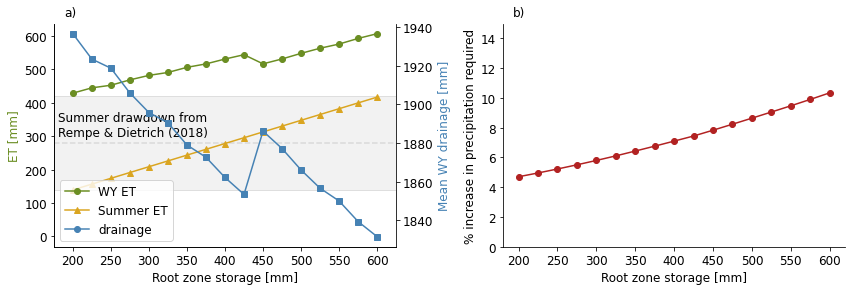

In [37]:

rzchangedf = pd.DataFrame.from_dict({'rzstore':list(testrange),
#                                      'soilstore':np.array(list(range(100,575,25)))/4.7,
                       'ET':etvals,
                        'ETsummer':etsummervals,
                        'd':dvals,
                       'PrecipError':perrs})


fig,axs = plt.subplots(1,2,figsize = (12,4))
ax = axs[0]
ax.plot(rzchangedf.rzstore,rzchangedf.ET,label='WY ET',c='olivedrab',marker='o')
ax.plot(rzchangedf.rzstore,rzchangedf.ETsummer,label='Summer ET',c='goldenrod',marker='^')
ax.plot([-1],[-1],c='steelblue',label='drainage',marker='o')
ax.legend(loc='lower left')
ax.set_xlim(175,625)
ax.axhspan(140,420,facecolor='grey',edgecolor = 'k',alpha=.1,zorder=-1)
ax.axhline(280,c='k',alpha=.1,zorder=-1,ls='--')
ax.text(180,300,'Summer drawdown from\nRempe & Dietrich (2018)')

ax1=ax.twinx()
ax1.plot(rzchangedf.rzstore,rzchangedf.d,label='drainage',c='steelblue',marker='s',)
ax.set_ylabel('ET [mm]',c='olivedrab')
ax1.set_ylabel('Mean WY drainage [mm]',c='steelblue')
ax.set_xlabel('Root zone storage [mm]')
for ax in [ax,ax1]:
    ax.spines['top'].set_visible(False)


ax = axs[1]
ax.plot(rzchangedf.rzstore,rzchangedf.PrecipError*100,
        marker='o',c='firebrick')
ax.set_ylim(0,15)
ax.set_ylabel('% increase in precipitation required')
ax.set_xlabel('Root zone storage [mm]')

fig.tight_layout()

labels = ['a)','b)','c)','d)','e)','f)','g)','h)','i)',
         'j)','k)','l)','m)','n)','o)','p)','q)','r)',
          's)','t)','u)','v)']
for i,ax in enumerate(axs.flatten()):
    for side in ['top','right']:
        ax.spines[side].set_visible(False)

    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0, 1.1, labels[i], transform=ax.transAxes + trans,
             verticalalignment='top', )
plt.savefig('rzstorage_sensitivity.png',format='png',dpi=300,bbox_inches='tight')

rzchangedf

Number of ports: 7
[92.82362296 92.54433817 73.49859864 65.7127174  27.07268308 23.84867633
 20.85644503 14.81765063 13.82526774]
To meet mass balance, increased overall P by  7 %
544.109794491365 29775.448725416


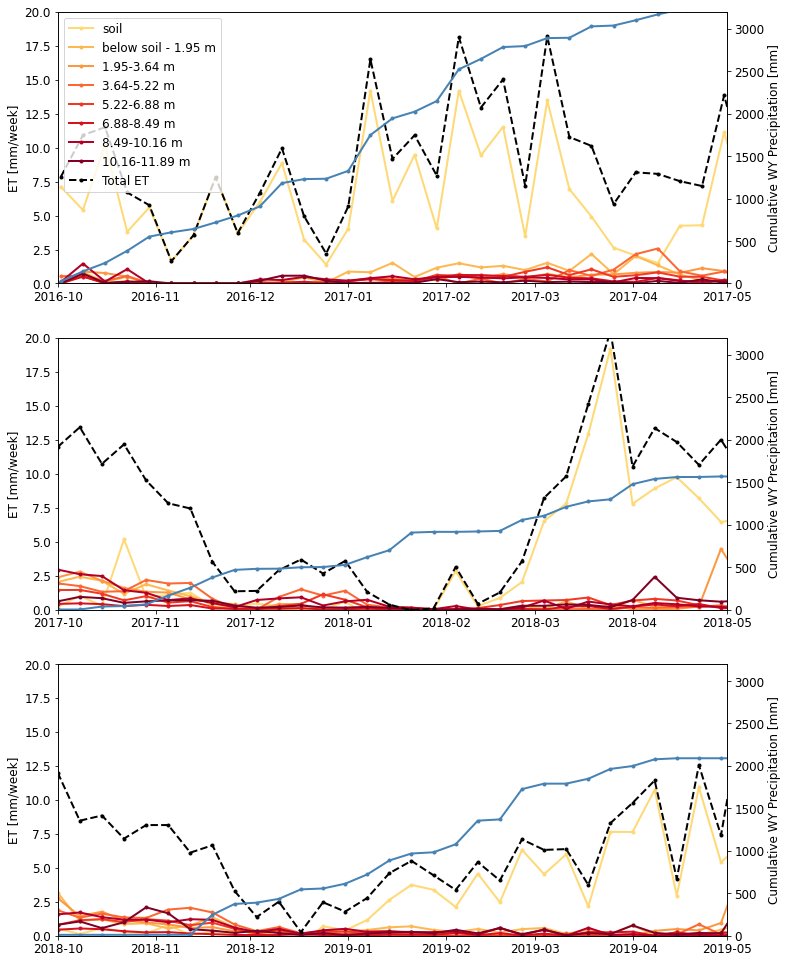

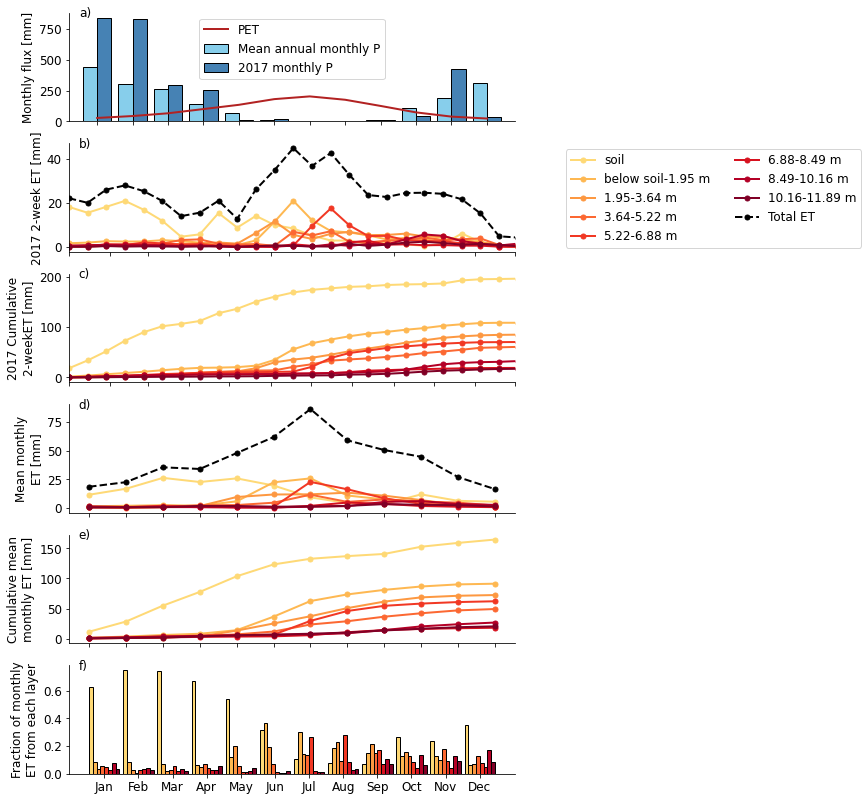

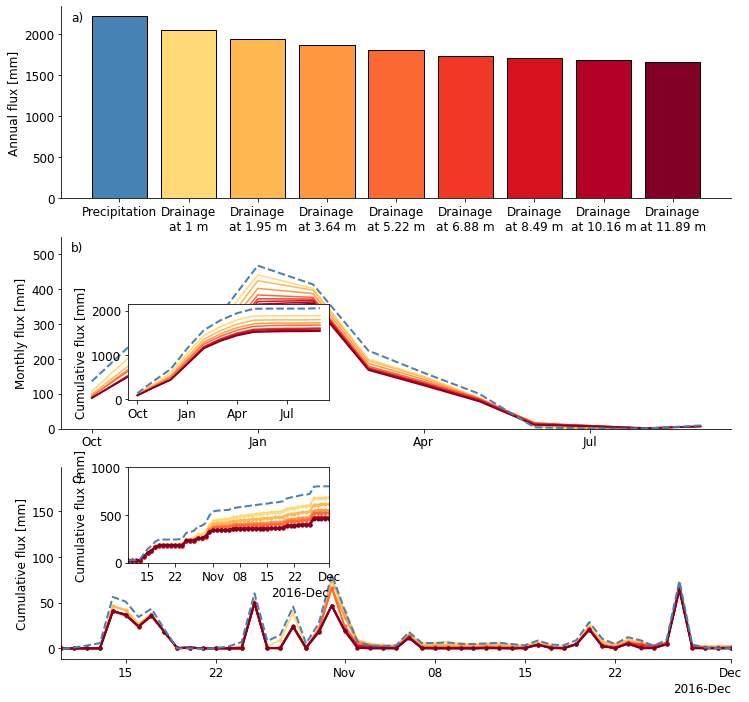

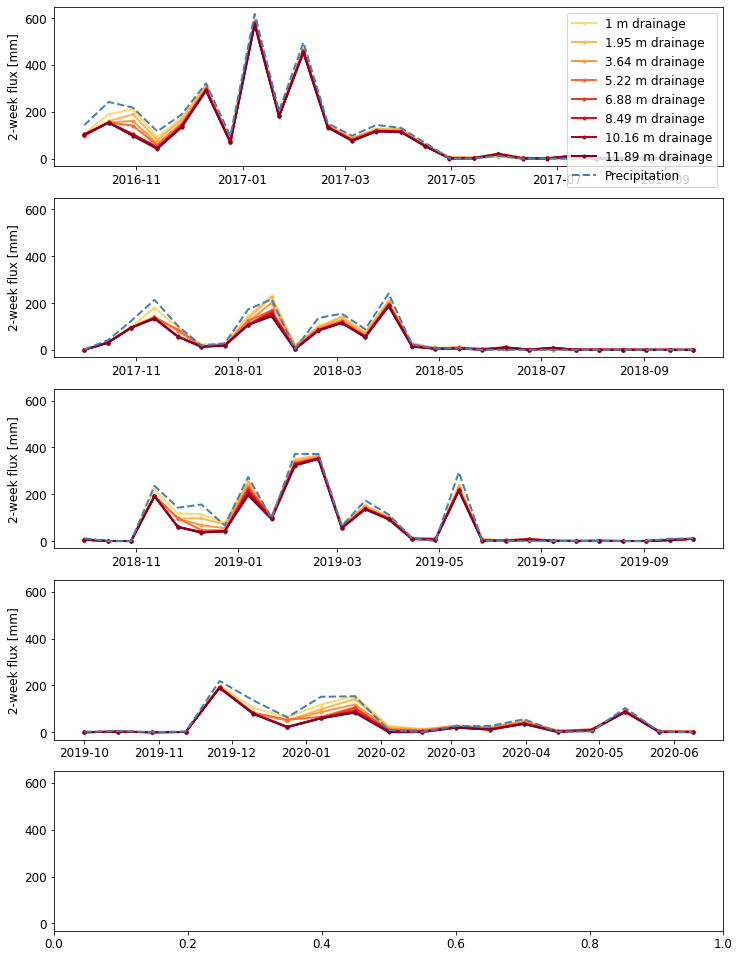

In [60]:
# run mass balance technique for all possible maximum depths

all_outputs = []
rdstore = 425
portuse = 7

for num_ports in [7]:#range(2,8):
    print('Number of ports:',num_ports)

    pet,popt,tdtData,tdr_norm,rainData = import_data(num_ports)
    Storages = setup_storage(popt,tdtData,tdr_norm,rdstore,num_ports,'exp')
    DeltaStorage = calc_deltastorage(Storages,rainData)
    DeltaStorage = calc_massbalance(DeltaStorage)
    if num_ports==portuse:
        make_plots(DeltaStorage)

    DS_sub = DeltaStorage.loc['2016-10-01':'2019-10-01']

    print(DS_sub.ET_total.mean()*365,
          DeltaStorage.ET_total.mean()*365/DeltaStorage.Jadjust.mean()*365)
    
    all_outputs.append(DeltaStorage)



In [89]:
DeltaStorage = all_outputs[portuse-2]

In [61]:
wysum = DeltaStorage.groupby('wy').sum()
(wysum.ET0/wysum.ET_total).iloc[1:-1].mean()

0.31492288320535405

In [62]:
# make a cumulative rainfall column for each water year

Jcum = []
for wy in DeltaStorage.wy.unique():
    wysub = DeltaStorage[DeltaStorage.wy==wy]
    Jcum.append(wysub.Jadjust.cumsum())
Jcum = pd.concat(Jcum)
DeltaStorage['Jcum'] = Jcum

In [63]:
###############
# mass balance calcs
import dataretrieval.nwis as nwis

streamflow = nwis.get_record(sites='11475560', service='iv', 
                             start='2015-10-01', end='2022-10-01',parameterCd='00060').reset_index()#pd.read_csv('../Data/Elder_streamflow.txt',sep='\t').iloc[1:]
streamflow['datetime'] = pd.to_datetime(streamflow.datetime)
streamflow.set_index('datetime',inplace=True)
streamflow = streamflow[['00060']].resample('D').mean()
streamflow['Q_m3/s'] = streamflow['00060'].astype('float')*12**3*2.54**3/100**3
streamflow['Q_mm/d'] = streamflow['Q_m3/s']*60*60*24/(1.683e+7)*1000
Q_mm_yr = streamflow['Q_mm/d'].mean()*365
d_mm_yr = DeltaStorage.loc['2016-10-01':'2019-10-01'].mean()['d'+str(portuse)]*365
J_mm_yr = (rainData.loc['2016-10-10':'2019-10-01']['J [mm/h]'].mean()*365*24)
print('Mean annual ET from mass balance: ',(J_mm_yr*.8-Q_mm_yr),'-',(J_mm_yr*.9-Q_mm_yr))
print('Q',Q_mm_yr,', drainage',d_mm_yr,', difference of ',d_mm_yr-Q_mm_yr)


Mean annual ET from mass balance:  1067.425932077365 - 1335.2861493219903
Q 1075.4558058796392 , drainage 1853.428687249555 , difference of  777.9728813699157


In [64]:
DeltaStorage[DeltaStorage.index.month.isin([6,7,8,9])].groupby('wy').sum()[['ET'+str(i) for i in range(1,8)]].sum(axis=1)

wy
2017    244.119183
2018    221.738644
2019    231.357826
2020      9.820115
dtype: float64

continue


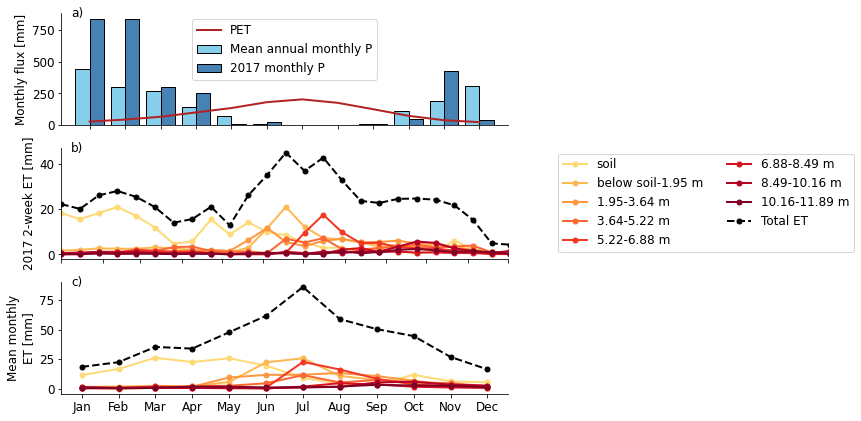

In [65]:
# plot the monthly ET signal
try:
    DeltaStorage = DeltaStorage.drop(columns=['month','season'])
except:
    print('continue')
plotcolors = pl.cm.YlOrRd(np.linspace(0.25,1,num_ports+1))
colors = plotcolors
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
Fig,axs = plt.subplots(3,figsize = (8,7))

ax = axs[0]
rainData['month'] = rainData.reset_index()['index'].dt.month.values
monthlyrain = rainData.groupby('month').mean()['J [mm/h]']
ax.bar(monthlyrain.index-.2,
       monthlyrain*30*24,
       facecolor = 'skyblue',edgecolor = 'k',label='Mean annual monthly P',
      width = .4)
ax.bar(monthlyrain.index+.2,
       rainData[rainData.reset_index()['index'].dt.year.values==2017].resample('M').sum()['J [mm/h]'],
      facecolor = 'steelblue',edgecolor = 'k',width = .4,label = '2017 monthly P')
ax.set_xticks(list(range(1,13)))
ax.set_xticklabels(months)
ax.plot([-1,-1],[0,1],c='firebrick',lw=2,label='PET')
ax.legend()
ax.set_ylabel('Monthly flux [mm]')
ax.spines['top'].set_visible(False)
ax.set_xlim(0.2,12.8)

axt = ax
petdata = DeltaStorage[['PET_mmd']]
petdata['month'] = petdata.reset_index()['index'].dt.month.values
axt.plot(petdata.groupby('month').mean().index.values,
         (petdata.groupby('month').mean()*30).values,c='firebrick',label='PET',lw=2)
axt.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = axs[1]

for i,yr in enumerate([2017]):
    yrdata = DeltaStorage[DeltaStorage.index.year==yr].resample('14D').sum()
    for j in range(num_ports+1):
        lownum = 0
        pdepth = 1
        if j==1:
            lownum = 1
            pdepth = port_depths[j-1]
        elif j>1:
            lownum = port_depths[j-2]
            pdepth = port_depths[j-1]
        plotlabel = str(round(lownum,2))+'-'+str(round(pdepth,2)) + ' m'
        if '0-1' in plotlabel:
            plotlabel = 'soil'
        elif '1-1' in plotlabel:
            plotlabel = 'below soil-1.95 m'
        ax.plot(yrdata.index,
                     yrdata['ET'+str(j)],marker='o',markersize=5, 
                                   lw=2,label =plotlabel,c=plotcolors[j]
                                  )
    ax.plot(yrdata.index,yrdata.ET_total,lw=2,label='Total ET',marker='o',markersize = 5,ls='--',c='k')
    ax.set_xlim(pd.to_datetime('1-1-'+str(yr)),
                pd.to_datetime('12-1-'+str(yr)))
    ax.set_ylabel('2017 2-week ET [mm]')
    if i==0:
        ax.legend(loc = 'upper left',ncol=2,bbox_to_anchor = (1.1,1.))
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax = axs[2]


Smonth = DeltaStorage.resample('M').mean()
Smonth['Month'] = Smonth.index.month
for i in list(range(num_ports+1)):
    lownum = 0
    pdepth = 1
    if i==1:
        lownum = 1
        pdepth = port_depths[i-1]
    elif i>1:
        lownum = port_depths[i-2]
        pdepth = port_depths[i-1]
    smonth_indiv = Smonth.groupby('Month').mean()[['ET'+str(i)]]*30
    ax.plot(smonth_indiv.index,smonth_indiv.values,
            lw=2,marker='o',markersize = 5,
            label = str(round(lownum,2))+'-'+str(round(port_depths[i],2))+' m',
            c = plotcolors[i]
           )
smonth_indiv = Smonth.groupby('Month').mean()[['ET_total']]*30
ax.plot(smonth_indiv.index,
       smonth_indiv.values,lw=2,marker='o',markersize = 5,
       label = 'Total ET',ls='--',c='k')
ax.set_ylabel('Mean monthly\nET [mm]')
ax.set_xticks(range(1,13))
ax.set_xticklabels(months)



labels = ['a)','b)','c)','d)','e)','f)','g)','h)','i)','j)']
for i,ax in enumerate(axs.flatten()):#[:-1]):
    # label physical distance in and down:
    ax.spines[['top','right']].set_visible(False)
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.1, labels[i], transform=ax.transAxes + trans,
             verticalalignment='top', )
    if i<len(axs)-1:
        ax.set_xticklabels([])
#     axs[3,1].axis('off')
#     axs[0,1].axis('off')

plt.savefig('VMS_fluxes_numports_'+str(num_ports)+'_small.png',format='png',dpi=300,bbox_inches='tight')

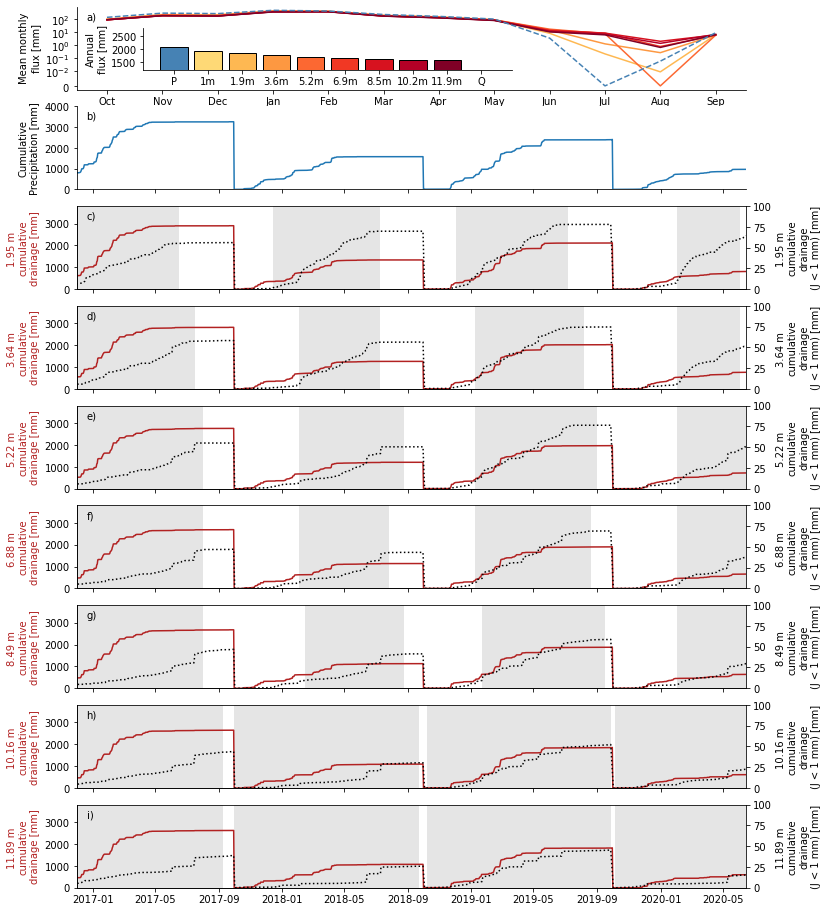

In [66]:
import matplotlib

# plot drainage results with sample dates
colors = pl.cm.YlOrRd(np.linspace(0.25,1,portuse+1))
matplotlib.rcParams.update({'font.size': 10})
import datetime
fig,axs = plt.subplots(2+portuse,figsize = (12,2*(2+portuse)),)
DeltaStorage['month'] = DeltaStorage.index.month

ax = axs[0]
DSmonth = DeltaStorage.groupby('month').mean()*30
DSmonth = pd.concat([DSmonth.loc[10:],DSmonth.loc[:9]])
for i in range(1,portuse+1):
    ax.plot(DSmonth.index.astype('str'),DSmonth['d'+str(i)],
           c = colors[i],)
ax.plot(DSmonth.index.astype('str'),
       DSmonth.Jadjust,c='steelblue',ls='--',label = 'P')
ax.set_ylabel('Mean monthly\nflux [mm]')
ax.set_xticklabels(['Oct','Nov','Dec','Jan','Feb','Mar','Apr',
                  'May','Jun','Jul','Aug','Sep'])
ax.set_yscale('symlog',linthresh=.01)

axins = ax.inset_axes([.1,.24,.55,.5])#[.5,.65,.6,.5])
DSannual = DSmonth[['Jadjust']+['d'+str(i) for i in range(portuse+1)]].mean()/30*365
for i in range(len(DSannual)):
    axins.bar([i],
          [DSannual.values[i]],
           facecolor = (['steelblue']+list(colors))[i],
             edgecolor = 'k')
axins.bar([i+1],[Q_mm_yr],facecolor = 'skyblue',edgecolor = 'k')
axins.set_xticks(list(range(len(DSannual)+1)))
axins.set_xticklabels(['P']+[str(round(([1]+port_depths)[i],1))+'m' for i in range(portuse+1)]+['Q'])
axins.set_ylabel('Annual\nflux [mm]')
axins.spines[['top','right']].set_visible(False)
axins.set_ylim(1200,2800)

ax = axs[1]
DeltaStorage.Jcum.plot(ax=ax)
ax.set_xlim(pd.to_datetime(DeltaStorage.index.values[0])+datetime.timedelta(60),
                DeltaStorage.index.values[-1])
ax.set_xticklabels([])
ax.set_ylabel('Cumulative\nPrecipitation [mm]')
ax.set_ylim(0,4000)

for i in range(portuse):
    ax = axs[i+2]
    dscum = []
    dmincum = []
    for yr in DeltaStorage.wy.unique():
        subset = DeltaStorage[(DeltaStorage.wy==yr)]
        subset1 = DeltaStorage[(DeltaStorage.wy==yr) & (DeltaStorage.Jadjust<1)]
        dscum.append(subset['d'+str(i+1)].cumsum())
        dmincum.append(subset1['d'+str(i+1)].cumsum())
    dscum = pd.concat(dscum)
    dmincum = pd.concat(dmincum)
    ax.plot(dscum,
                c='firebrick',)#colors[i])
    axtwin = ax.twinx()
    axtwin.plot(dmincum,
            c='k',#colors[i],
                ls=':')
    ax.set_ylabel(str(port_depths[i])+' m \ncumulative\ndrainage [mm]',c='firebrick')
    axtwin.set_ylabel(str(port_depths[i])+' m \ncumulative\ndrainage\n(J < 1 mm) [mm]')
    if i<6:
        ax.set_xticklabels([])
    ax.set_xlim(pd.to_datetime(DeltaStorage.index.values[0])+datetime.timedelta(60),
                DeltaStorage.index.values[-1])
    ax.set_ylim(0,3800)
    axtwin.set_ylim(0,100)
    

    dat = first_last_dates_water_year[first_last_dates_water_year['Location']=='A'+str(i+1)]
    for _, row in dat.iterrows():
        ax.axvspan(row['Last Date'], row['First Date']-datetime.timedelta(7), 
                   alpha=.1,facecolor='k')

labels = ['a)','b)','c)','d)','e)','f)','g)','h)','i)',
         'j)','k)','l)','m)','n)','o)','p)','q)','r)',
          's)','t)','u)','v)']
for i,ax in enumerate(axs.flatten()):
    for side in ['top','right']:
        ax.spines[side].set_visible(False)

    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0, 1., labels[i], transform=ax.transAxes + trans,
             verticalalignment='top', )
    
plt.savefig('drainage_align_samples.png',format='png',dpi=300,bbox_inches='tight')

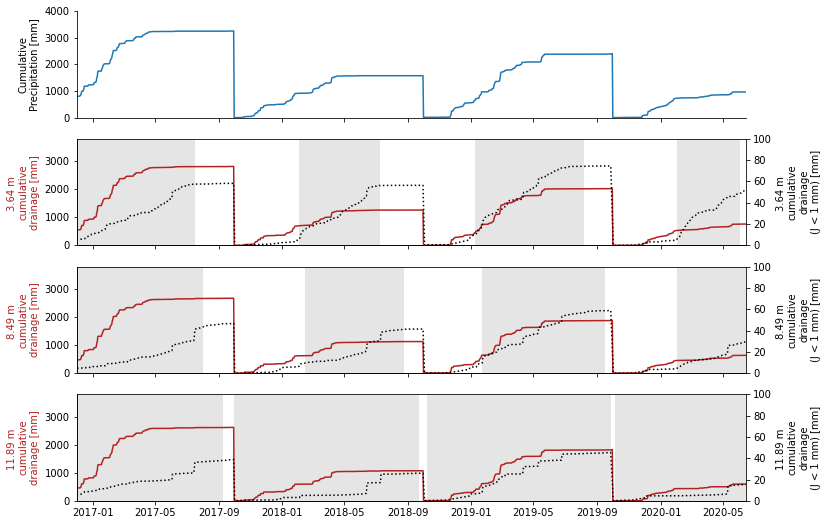

In [89]:
import matplotlib

# plot drainage results with sample dates
colors = pl.cm.YlOrRd(np.linspace(0.25,1,portuse+1))
matplotlib.rcParams.update({'font.size': 10})
import datetime
fig,axs = plt.subplots(4,figsize = (12,10))
DeltaStorage['month'] = DeltaStorage.index.month

ax = axs[0]
DeltaStorage.Jcum.plot(ax=ax)
ax.set_xlim(pd.to_datetime(DeltaStorage.index.values[0])+datetime.timedelta(60),
                DeltaStorage.index.values[-1])
ax.set_xticklabels([])
ax.set_ylabel('Cumulative\nPrecipitation [mm]')
ax.set_ylim(0,4000)

for j,i in enumerate([1,4,portuse-1]):
    ax = axs[1+j]
    dscum = []
    dmincum = []
    for yr in DeltaStorage.wy.unique():
        subset = DeltaStorage[(DeltaStorage.wy==yr)]
        subset1 = DeltaStorage[(DeltaStorage.wy==yr) & (DeltaStorage.Jadjust<1)]
        dscum.append(subset['d'+str(i+1)].cumsum())
        dmincum.append(subset1['d'+str(i+1)].cumsum())
    dscum = pd.concat(dscum)
    dmincum = pd.concat(dmincum)
    ax.plot(dscum,
                c='firebrick',)#colors[i])
    axtwin = ax.twinx()
    axtwin.plot(dmincum,
            c='k',#colors[i],
                ls=':')
    ax.set_ylabel(str(port_depths[i])+' m \ncumulative\ndrainage [mm]',c='firebrick')
    axtwin.set_ylabel(str(port_depths[i])+' m \ncumulative\ndrainage\n(J < 1 mm) [mm]')
    if i<6:
        ax.set_xticklabels([])
    ax.set_xlim(pd.to_datetime(DeltaStorage.index.values[0])+datetime.timedelta(60),
                DeltaStorage.index.values[-1])
    ax.set_ylim(0,3800)
    axtwin.set_ylim(0,100)
    

    dat = first_last_dates_water_year[first_last_dates_water_year['Location']=='A'+str(i+1)]
    for _, row in dat.iterrows():
        ax.axvspan(row['Last Date'], row['First Date']-datetime.timedelta(7), 
                   alpha=.1,facecolor='k')

# labels = ['a)','b)','c)','d)','e)','f)','g)','h)','i)',
#          'j)','k)','l)','m)','n)','o)','p)','q)','r)',
#           's)','t)','u)','v)']
for i,ax in enumerate(axs.flatten()):
    for side in ['top','right']:
        ax.spines[side].set_visible(False)

#     # label physical distance in and down:
#     trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
#     ax.text(0, 1., labels[i], transform=ax.transAxes + trans,
#              verticalalignment='top', )
    
plt.savefig('drainage_align_samples_poster.png',format='png',dpi=300,bbox_inches='tight')

In [67]:
# label three seasons, approximately winter, spring, and summer
# but names just used for labeling purposes

DeltaStorage['season'] = np.where(DeltaStorage.month.isin([10,11,12,1]),
                                 'winter',np.nan)
DeltaStorage['season'] = np.where(DeltaStorage.month.isin([2,3,4,5]),
                                 'spring',DeltaStorage.season)
DeltaStorage['season'] = np.where(DeltaStorage.month.isin([6,7,8,9]),
                                 'summer',DeltaStorage.season)

In [68]:
# yrsums

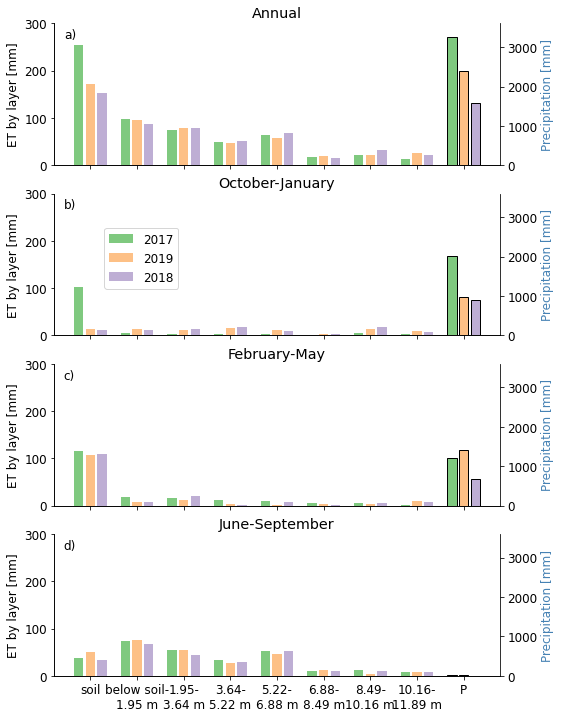

In [69]:
# compare ET magnitudes at different depths annually and seasonally
# for three water years with different precipitation
matplotlib.rcParams.update({'font.size': 12})
yrsums = DeltaStorage.groupby('wy').sum().iloc[:-1][['Jadjust']+['ET'+str(i) for i in range(portuse,-1,-1)]]
seasonsums = DeltaStorage.groupby(['wy','season']).sum()[['Jadjust']+['ET'+str(i) for i in range(portuse,-1,-1)]]

fig,axs = plt.subplots(4,figsize = (8,12),sharex=True,sharey=True)
yrs = [2017,2019,2018]
hatches = ['','','']#'//','.']
wycolors = matplotlib.colormaps['Accent'](np.linspace(0,1,8)[:3])
wycolors = {2017:wycolors[0],
           2018:wycolors[1],
           2019:wycolors[2]}

ax = axs[1-1]
axt = ax.twinx()
axt.spines['top'].set_visible(False)
axt.set_ylabel('Precipitation [mm]',c='steelblue')
for j,yr in enumerate(yrs):
    for i in range((portuse+1)):
        if i==0:
            lab = yr
        else:
            lab = None
        ax.bar(i-.25+j/4,yrsums['ET'+str(i)].loc[yr],
              facecolor = wycolors[yr],width = .2,hatch=hatches[j],label=lab)
    MAP = yrsums.Jadjust.loc[yr]
    yloc = yrsums.ET0.loc[yr]
    axt.bar(i+1-.25+j/4,yrsums.Jadjust.loc[yr],
           width = .2,facecolor = wycolors[yr],hatch = hatches[j],edgecolor = 'k')
    axt.set_ylim(0,3600)
ax.set_xticks(list(range(portuse+2)))
ticknames = [str(([0,'below soil']+port_depths)[i])+'-\n'+
                   str(([0,'below soil']+port_depths)[i+1])+' m' for i in range(portuse+1)]+['P']
ticknames[0] = 'soil'
ax.set_xticklabels(ticknames)
ax.set_ylabel('ET by layer [mm]')
# ax.legend(loc='upper left',bbox_to_anchor = (.1,-.51))
ax.set_title('Annual')

months = ['October-January','February-May','June-September']
for k,season in enumerate(['winter','spring','summer']):
    ax = axs[2+k-1]
    axt = ax.twinx()
    for j,yr in enumerate(yrs):
        for i in range((portuse+1)):
            if i==0:
                lab = yr
            else:
                lab = None
            ax.bar(i-.25+j/4,seasonsums['ET'+str(i)].loc[yr,season],
                  facecolor = wycolors[yr],width = .2,hatch=hatches[j],label=lab)
        axt.bar(i+1-.25+j/4,seasonsums.Jadjust.loc[yr,season],
           width = .2,facecolor = wycolors[yr],edgecolor = 'k',hatch=hatches[j],label=lab)
    if k==0:
        ax.legend(loc='upper left',bbox_to_anchor = (0.1,.8))
    ax.set_ylabel('ET by layer [mm]')
    ax.set_ylim(0,300)
    ax.set_title(months[k])
    axt.set_ylim(0,3600)
    axt.spines[['top',]].set_visible(False)
    axt.set_ylabel('Precipitation [mm]',c='steelblue')
    
for ax in axs:
    ax.spines[['top','right']].set_visible(False)
    
labels = ['a)','b)','c)','d)','e)','f)','g)','h)','i)',
         'j)','k)','l)','m)','n)','o)','p)','q)','r)',
          's)','t)','u)','v)']
for i,ax in enumerate(axs.flatten()):
    for side in ['top','right']:
        ax.spines[side].set_visible(False)

    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0, 1., labels[i], transform=ax.transAxes + trans,
             verticalalignment='top', )
    
plt.savefig('et_p_seasons_yrcolor.png',format='png',dpi=300,bbox_inches='tight')

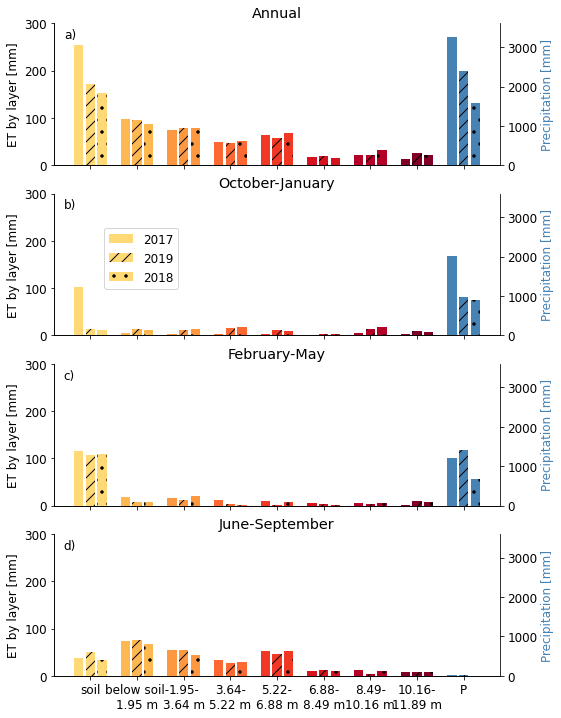

In [70]:
# compare ET magnitudes at different depths annually and seasonally
# for three water years with different precipitation
matplotlib.rcParams.update({'font.size': 12})
yrsums = DeltaStorage.groupby('wy').sum().iloc[:-1][['Jadjust']+['ET'+str(i) for i in range(portuse,-1,-1)]]
seasonsums = DeltaStorage.groupby(['wy','season']).sum()[['Jadjust']+['ET'+str(i) for i in range(portuse,-1,-1)]]

fig,axs = plt.subplots(4,figsize = (8,12),sharex=True,sharey=True)
yrs = [2017,2019,2018]
hatches = ['','//','.']


ax = axs[1-1]
axt = ax.twinx()
axt.spines['top'].set_visible(False)
axt.set_ylabel('Precipitation [mm]',c='steelblue')
for j,yr in enumerate(yrs):
    for i in range((portuse+1)):
        if i==0:
            lab = yr
        else:
            lab = None
        ax.bar(i-.25+j/4,yrsums['ET'+str(i)].loc[yr],
              facecolor = colors[i],width = .2,hatch=hatches[j],label=lab)
    MAP = yrsums.Jadjust.loc[yr]
    yloc = yrsums.ET0.loc[yr]
    axt.bar(i+1-.25+j/4,yrsums.Jadjust.loc[yr],
           width = .2,facecolor = 'steelblue',hatch = hatches[j])
    axt.set_ylim(0,3600)
ax.set_xticks(list(range(portuse+2)))
ticknames = [str(([0,'below soil']+port_depths)[i])+'-\n'+
                   str(([0,'below soil']+port_depths)[i+1])+' m' for i in range(portuse+1)]+['P']
ticknames[0] = 'soil'
ax.set_xticklabels(ticknames)
ax.set_ylabel('ET by layer [mm]')
# ax.legend(loc='upper left',bbox_to_anchor = (.1,-.51))
ax.set_title('Annual')

months = ['October-January','February-May','June-September']
for k,season in enumerate(['winter','spring','summer']):
    ax = axs[2+k-1]
    axt = ax.twinx()
    for j,yr in enumerate(yrs):
        for i in range((portuse+1)):
            if i==0:
                lab = yr
            else:
                lab = None
            ax.bar(i-.25+j/4,seasonsums['ET'+str(i)].loc[yr,season],
                  facecolor = colors[i],width = .2,hatch=hatches[j],label=lab)
        axt.bar(i+1-.25+j/4,seasonsums.Jadjust.loc[yr,season],
           width = .2,facecolor = 'steelblue',hatch=hatches[j],label=lab)
    if k==0:
        ax.legend(loc='upper left',bbox_to_anchor = (0.1,.8))
    ax.set_ylabel('ET by layer [mm]')
    ax.set_ylim(0,300)
    ax.set_title(months[k])
    axt.set_ylim(0,3600)
    axt.spines[['top',]].set_visible(False)
    axt.set_ylabel('Precipitation [mm]',c='steelblue')
    
for ax in axs:
    ax.spines[['top','right']].set_visible(False)
    
labels = ['a)','b)','c)','d)','e)','f)','g)','h)','i)',
         'j)','k)','l)','m)','n)','o)','p)','q)','r)',
          's)','t)','u)','v)']
for i,ax in enumerate(axs.flatten()):
    for side in ['top','right']:
        ax.spines[side].set_visible(False)

    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0, 1., labels[i], transform=ax.transAxes + trans,
             verticalalignment='top', )
    
plt.savefig('et_p_seasons.png',format='png',dpi=300,bbox_inches='tight')

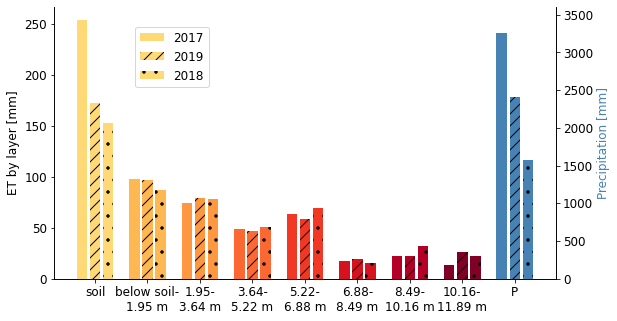

In [82]:
# compare ET magnitudes at different depths annually and seasonally
# for three water years with different precipitation
matplotlib.rcParams.update({'font.size': 12})
yrsums = DeltaStorage.groupby('wy').sum().iloc[:-1][['Jadjust']+['ET'+str(i) for i in range(portuse,-1,-1)]]
seasonsums = DeltaStorage.groupby(['wy','season']).sum()[['Jadjust']+['ET'+str(i) for i in range(portuse,-1,-1)]]

fig,axs = plt.subplots(1,figsize = (9,5),sharex=True,sharey=True)
yrs = [2017,2019,2018]
hatches = ['','//','.']


ax = axs
axt = ax.twinx()
axt.spines['top'].set_visible(False)
axt.set_ylabel('Precipitation [mm]',c='steelblue')
for j,yr in enumerate(yrs):
    for i in range((portuse+1)):
        if i==0:
            lab = yr
        else:
            lab = None
        ax.bar(i-.25+j/4,yrsums['ET'+str(i)].loc[yr],
              facecolor = colors[i],width = .2,hatch=hatches[j],label=lab)
    MAP = yrsums.Jadjust.loc[yr]
    yloc = yrsums.ET0.loc[yr]
    axt.bar(i+1-.25+j/4,yrsums.Jadjust.loc[yr],
           width = .2,facecolor = 'steelblue',hatch = hatches[j])
    axt.set_ylim(0,3600)
ax.set_xticks(list(range(portuse+2)))
ticknames = [str(([0,'below soil']+port_depths)[i])+'-\n'+
                   str(([0,'below soil']+port_depths)[i+1])+' m' for i in range(portuse+1)]+['P']
ticknames[0] = 'soil'
ax.set_xticklabels(ticknames)
ax.set_ylabel('ET by layer [mm]')
# ax.legend(loc='upper left',bbox_to_anchor = (.1,-.51))
# ax.set_title('Annual')

ax.legend(loc='upper left',bbox_to_anchor = (.15,.95))
ax.spines[['top']].set_visible(False)

    
plt.savefig('et_p_seasons_annual.png',format='png',dpi=300,bbox_inches='tight')

In [48]:
wysum = DeltaStorage[DeltaStorage.index.month.isin([6,7,8,9])].groupby('wy').sum().iloc[1:-1]
# 1-(wysum.ET0/wysum.ET_total)
(wysum.ET0/wysum.ET_total).mean()-1

-0.8462846486637363

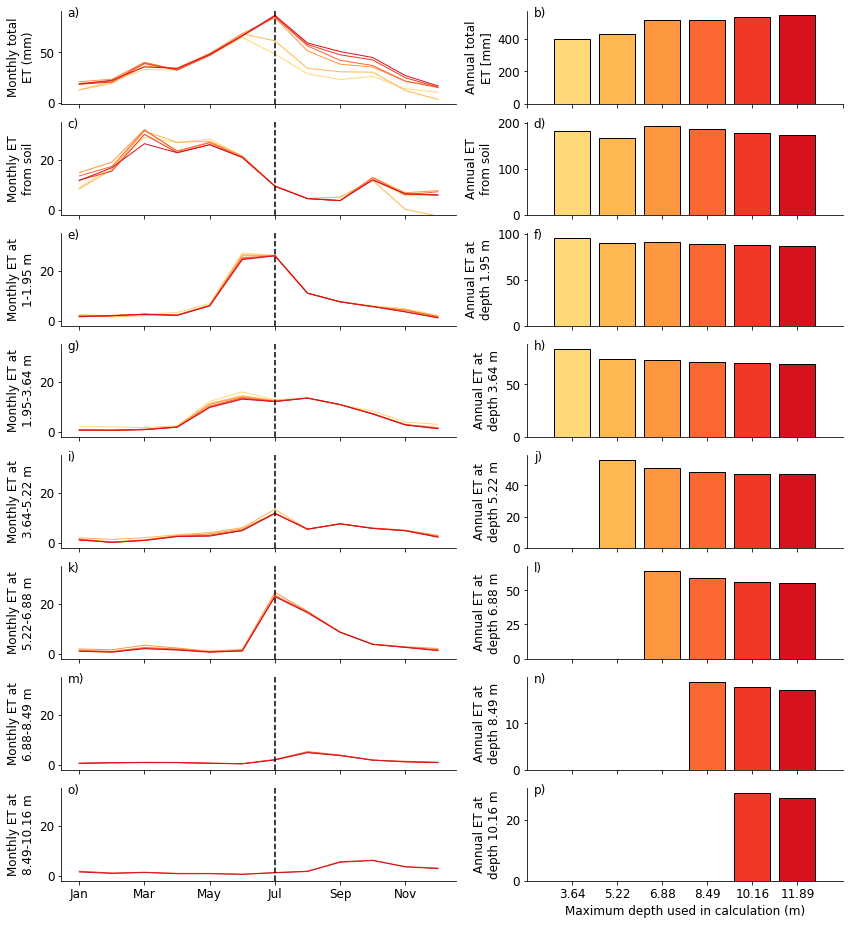

In [50]:
# plot timing of mean annual ET patterns
# and how maximum depth affects this

fig,axs = plt.subplots(1+portuse,2,figsize = (14,(1+portuse)*2),
                      gridspec_kw={'width_ratios':[5,4]})

colors = pl.cm.YlOrRd(np.linspace(0.25,1,portuse+1))

ax = axs[0,0]
for i in range(len(all_outputs)):
    try:
        DS = all_outputs[i].drop(columns='season')
    except:
        DS = all_outputs[i]
    DS['month'] = DS.index.month
    DS = DS.groupby('month').mean()*30
    if i==4:
        lw = 1#3
        ls = 'solid'#':'
    else:
        lw = 1
        ls = 'solid'
    ax.plot(DS.index,
            DS.ET_total,label='Max. depth: '+str(port_depths[i+1])+' m',c=colors[i],
           lw = lw, ls = ls)
# ax.legend(loc = 'upper left',bbox_to_anchor = (.05,1.4))
ax.set_ylabel('Monthly total\nET (mm)')
ax.set_xticks([1,3,5,7,9,11])
ax.set_xticklabels([])
ax.axvline(7,c='k',ls='--')

ax = axs[0,1]
for i in range(len(all_outputs)):
#     print (i)
    try:
        DS = all_outputs[i].loc['2016-10-01':'2019-10-01'].mean()*365
    except:
        DS = all_outputs[i].drop(columns='season').loc['2016-10-01':'2019-10-01'].mean()*365
    if i==4:
        lw = 1#3
    else:
        lw = 1
    ax.bar([i+2],[DS.ET_total],edgecolor = 'k',facecolor = colors[i],lw=lw)
ax.set_xticklabels([])
ax.set_xlim(1,portuse+1)
ax.set_ylabel('Annual total\nET [mm]')

for port in range(portuse):
    ax = axs[port+1,0]
    for i in range(len(all_outputs)):
        try:
            DS = all_outputs[i].drop(columns='season')
        except:
            DS = all_outputs[i]
        DS['month'] = DS.index.month
        DS = DS.groupby('month').mean()*30
        if i==4:
            lw = 1#3
            ls = 'solid'#':'
        else:
            lw = 1
            ls = 'solid'
        try:
            ax.plot(DS.index,
                DS['ET'+str(port)],
                label=i+2,c=colors[i],lw = lw,ls=ls)
        except:
            continue
    if port==0:
        portdepth = 1
        lownum = 0
    elif port==1:
        lownum = 1
        portdepth = port_depths[port-1]
    else:
        lownum = portdepth
        portdepth = port_depths[port-1]
    
    if lownum==0:
        ax.set_ylabel('Monthly ET\nfrom soil')
    else:
        ax.set_ylabel('Monthly ET at\n'+str(lownum)+'-'+str(portdepth)+' m')
    ax.set_ylim(-2,35)
    ax.axvline(7,c='k',ls='--')
    ax.set_xticks([1,3,5,7,9,11])
    ax.set_xticklabels([])
    
    
ax.set_xticklabels(['Jan','Mar','May','Jul','Sep','Nov']) 
    
for port in range(portuse):
    ax = axs[port+1,1]
    for i in range(len(all_outputs)):
        try:
            DS = all_outputs[i].mean()*365
        except:
            DS = all_outputs[i].drop(columns='season').mean()*365
        if i==4:
            lw = 1#3
        else:
            lw = 1
        try:
            ax.bar([i+2],[DS['ET'+str(port)]],edgecolor = 'k',facecolor = colors[i],lw=lw)
        except:
            continue
    portdepth = port_depths[port-1]
    if port==0:
        portdepth = 0.6
    if portdepth==0.6:
        ax.set_ylabel('Annual ET\nfrom soil')
    else:
        ax.set_ylabel('Annual ET at\ndepth '+str(portdepth)+' m')
    ax.set_xlim(1,portuse+1)
    ax.set_xticks(list(range(2,portuse+1)))
    ax.set_xticklabels([])
#     ax.set_ylim(0,360)
ax.set_xticklabels([port_depths[i-1] for i in list(range(2,portuse+1))])
ax.set_xlabel('Maximum depth used in calculation (m)')


labels = ['a)','b)','c)','d)','e)','f)','g)','h)','i)',
         'j)','k)','l)','m)','n)','o)','p)','q)','r)',
          's)','t)','u)','v)']
for i,ax in enumerate(axs.flatten()):
    for side in ['top','right']:
        ax.spines[side].set_visible(False)

    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(-.01, 1.1, labels[i], transform=ax.transAxes + trans,
             verticalalignment='top', )
    
plt.savefig('compare_numports.png',format='png',dpi=300,bbox_inches='tight')

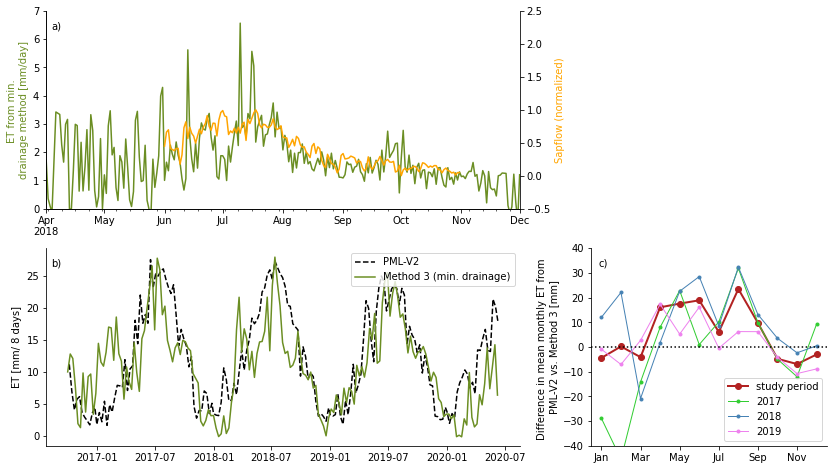

In [60]:
matplotlib.rcParams.update({'font.size': 10})
fig,axs = plt.subplots(2,2,figsize = (14,8
                                  ),gridspec_kw={'width_ratios':[2,1]})


ax = axs[0,0]
axt = ax.twinx()
sapflownorm.mean(axis=1).plot(ax=axt,label='Sapflow',c='orange')

DeltaStorage.ET_total.loc['2018-04-01':'2018-12-01'].plot(ax=ax,label='ET',
                                                         c='olivedrab')
# plt.legend()
ax.set_ylim(0,7)
ax.set_ylabel('ET from min. \ndrainage method [mm/day]',c='olivedrab')
axt.set_ylim(-.5,2.5)
axt.set_ylabel('Sapflow (normalized)', c = 'orange')


ax = axs[1,0]
ElderPML = pd.read_csv('../Data/ElderPML.csv',header=None).rename(columns={0:'date',1:'ET_PML'})
ElderPML['date'] = pd.to_datetime(ElderPML['date'])
ElderPML.set_index('date',inplace=True)
ElderPML = ElderPML.loc[DeltaStorage.index.values[0]:DeltaStorage.index.values[-1]]
axt2 = ax#.twinx()
axt2.plot(ElderPML.index,ElderPML.ET_PML,c='k',label='PML-V2',ls='--')
DS8day = DeltaStorage.ET_total.resample('8D').sum()
ax.plot(DS8day.index,DS8day,c='olivedrab',label='Method 3 (min. drainage)')
# ax.plot(DeltaStorage.index,DeltaStorage.ET_total,
#         c='olivedrab',label='min. drainage method',zorder=-1)
ax.legend(loc='upper right')
axt2.set_ylabel('ET from PML-V2 [mm/8 days]')
ax.set_ylabel('ET [mm/ 8 days]')#,c='olivedrab')
# for y in range(2016,2021):
#     ax.axvspan(pd.to_datetime('10-1-'+str(y)),pd.to_datetime('11-1-'+str(y)),
#               facecolor = 'olivedrab',alpha=.2,zorder=-1)
#     ax.axvspan(pd.to_datetime('4-1-'+str(y)),pd.to_datetime('9-1-'+str(y)),
#               facecolor = 'k',alpha=.05,zorder=-1)
# ax.set_xlim(DeltaStorage.index.values[0],DeltaStorage.index.values[-1])


ax = axs[1,1]
mlist = [7,8,9,]
ss = [DeltaStorage.index.values[0],
     pd.to_datetime('1-1-2017'),
     pd.to_datetime('1-1-2018'),
     pd.to_datetime('1-1-2019')]
es = [DeltaStorage.index.values[-1],
     pd.to_datetime('1-1-2018'),
     pd.to_datetime('1-1-2019'),
     pd.to_datetime('1-1-2020')]
cs = ['firebrick',
     'limegreen',
     'steelblue',
     'violet']
labs = ['study period',
       '2017','2018','2019']
lws = [2,1,1,1]
markers = ['o','.','.','.']
for j in range(4):
    s = ss[j]
    e = es[j]
    emonth = ElderPML.copy().loc[s:e]
    emonth = emonth.resample('D').first().interpolate()/8
    emonth = emonth.groupby(emonth.index.month).mean().ET_PML.values.flatten()*30
    dmonth = DeltaStorage.loc[s:e]
    dmonth = dmonth.groupby(dmonth.index.month).ET_total.mean().values*30
    ax.plot(emonth-dmonth,label = labs[j],c=cs[j],lw=lws[j],marker=markers[j])
ax.axhline(0,c='k',ls=':')
ax.set_ylabel('Difference in mean monthly ET from \nPML-V2 vs. Method 3 [mm]')
ax.set_xticks(list(range(0,12,2)))
ax.set_xticklabels(['Jan','Mar','May','Jul','Sep','Nov'])
# ax.axvspan(8.5,9.5,facecolor='olivedrab',alpha=.2,zorder=-1)
# ax.axvspan(2.5,7.5,facecolor = 'k',alpha=.05,zorder=-1)
ax.set_ylim(-40,40)
ax.legend()

# for ax in axs:
#     ax.spines[['top','right']].set_visible(False)
for ax in [axt,axt2]:
    ax.spines['top'].set_visible(False)

labels = ['a)','b)','c)','d)','e)','f)','g)','h)','i)',
         'j)','k)','l)','m)','n)','o)','p)','q)','r)',
          's)','t)','u)','v)']
for i,ax in enumerate([axs[0,0],axs[1,0],axs[1,1]]):
    for side in ['top','right']:
        ax.spines[side].set_visible(False)

    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(-.01, .975, labels[i], transform=ax.transAxes + trans,
             verticalalignment='top', )
axs[0,1].axis('off')
    
plt.savefig('ET_compare.png',format='png',dpi=300,bbox_inches='tight')

In [61]:
(emonth-dmonth)[3:8].sum()

44.31225296407048

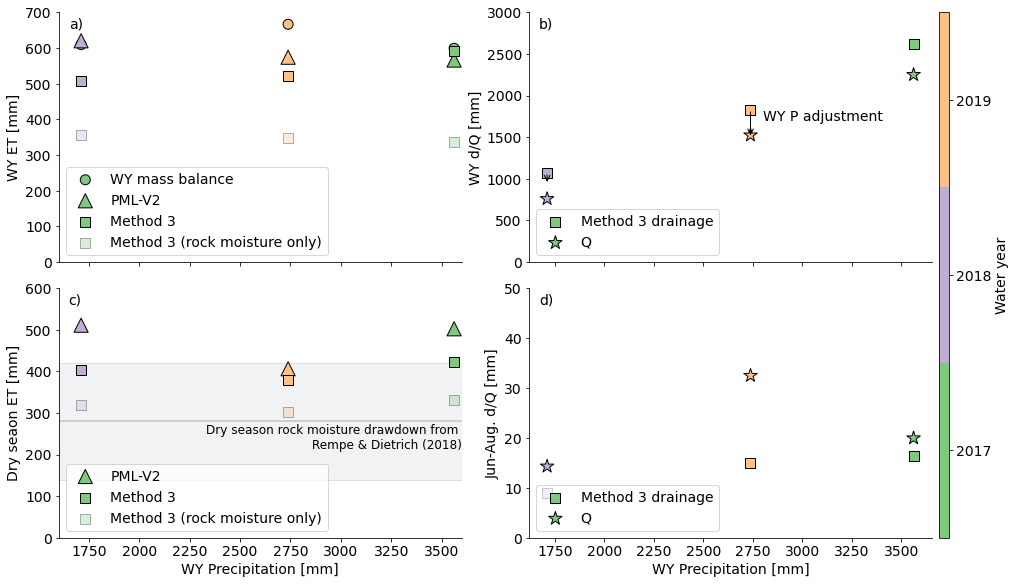

In [62]:
size = 100
vmax = 2024
cmap = 'Accent'
colors = plt.get_cmap(cmap,8)
import matplotlib
matplotlib.rcParams.update({'font.size': 14})


fig = plt.figure(constrained_layout=True, figsize = (14,8),
                )
spec = gridspec.GridSpec(ncols=3, nrows=2, figure=fig, width_ratios=[1,1,.025])

wyax = fig.add_subplot(spec[0, 0]) # this is annual
wyaxdrain = fig.add_subplot(spec[0,1])
axsummer = fig.add_subplot(spec[1,0])
axsummerdrain = fig.add_subplot(spec[1,1])
cax = fig.add_subplot(spec[:,-1])

for i,ax in enumerate([wyax,axsummer]):
    streamflow['wy'] = np.where(streamflow.index.month>9,
                               streamflow.index.year+1,
                               streamflow.index.year)

    rain = rainData[['J [mm/h]']].resample('D').sum()
#     if i==1:
#         rain = rain[rain.index.month.isin([6,7,8,9])]
    rain['wy'] = np.where(rain.index.month>9,
                         rain.index.year+1,
                         rain.index.year)
    sf = streamflow.groupby('wy').sum()[['Q_mm/d']]
    if i==1:
        sf = streamflow[streamflow.index.month.isin([5,6,7,8,9,10])]
        sf = sf.groupby(sf.index.year).sum()[['Q_mm/d']]
    mb = rain.groupby('wy').sum().merge(sf,left_index=True,right_index=True)
    mb['etdiff'] = mb[mb.columns[0]]*.8-mb['Q_mm/d']
    mb = mb.loc[2017:2019.5]
    if i==0:
        imv = ax.scatter(mb['J [mm/h]'],mb.etdiff,c=[colors(i) for i in range(3)],
        #             vmax=vmax,
                    s = size, label = 'WY mass balance',edgecolor = 'k',cmap=cmap)
#         plt.colorbar(imv)
#     ElderPML['wy'] = np.where(ElderPML.index.month>9,
#                              ElderPML.index.year+1,
#                              ElderPML.index.year)
#     EP = ElderPML.groupby('wy').sum().iloc[1:-1]
#     if i==1:
#         EP = ElderPML[ElderPML.index.month.isin([5,6,7,8,9,10])]
#         EP = EP.groupby(EP.index.year).sum().iloc[1:-1]
#     EP = EP.merge(rain.groupby('wy').sum(),left_index=True,right_index=True)
#     ax.scatter(EP['J [mm/h]'],EP.ET_PML,c=[colors(i) for i in range(3)],#vmin=2016,vmax=vmax,
#                 marker='^',
#                label = 'PML-V2', s = size*2, edgecolor = 'k',)#cmap=cmap)

    ax.set_ylabel('ET from mass balance [mm]')
#     plt.xlabel('WY Precip [mm]')

    dw = DeltaStorage.groupby('wy').sum().loc[2017:2019.5]
    if i==1:
        dw = DeltaStorage[DeltaStorage.index.month.isin([5,6,7,8,9,10])]
        dw = dw.groupby(dw.index.year).sum().loc[2017:2019.5]
        dws1= []
        dwrock = []
        EPS = []
        drains = []
        sfs = []
        for y in range(2017,2020):
            dw = DeltaStorage[DeltaStorage.index.year==y]
            rmsum = dw[['SA'+str(i) for i in range(1,8)]+['SSoil']].sum(axis=1)
            dwmax = dw[rmsum==rmsum.max()]
            dwmin = dw[rmsum==rmsum.min()]
            dw = dw.loc[dwmax.index.values[0]:dwmin.index.values[0]]
            dws1.append(dw.ET_total.sum())
            dwrock.append(dw[['ET'+str(i) for i in range(1,8)]].sum(axis=1).sum())
            EP = ElderPML.loc[pd.to_datetime(dwmax.index.values[0]):pd.to_datetime(dwmin.index.values[0])]
            EPS.append(EP.sum().ET_PML)
            drains.append(dw.d7.sum())
            streamflow = streamflow.reset_index()
            streamflow['datetime'] = streamflow['datetime'].apply(lambda x: x.replace(tzinfo=None))
            streamflow.set_index('datetime',inplace=True)
            sf = streamflow.loc[dwmax.index.values[0]:dwmin.index.values[0]]
            sfs.append(sf['Q_mm/d'].sum())
#             print(y,dwmax.index,dwmin.index)
    else:
        dws = dw
        dws1 = dw.ET_total
        dwrock = dw[['ET'+str(i) for i in range(1,8)]].sum(axis=1)
        ElderPML['wy'] = np.where(ElderPML.index.month>9,
                                 ElderPML.index.year+1,
                                 ElderPML.index.year)
        EPS = ElderPML.groupby('wy').sum().iloc[:-1].ET_PML
        drains = dw.d7
        sfs = streamflow.groupby('wy').sum()['Q_mm/d'].loc[2017:2019.5]
#     dw = dw.merge(mb,left_index=True,right_index=True)

    
    if i==1:
        ax1 = axsummerdrain
    else:
        ax1 = wyaxdrain
        ax1.scatter(mb['J [mm/h]'],drains,edgecolor = 'k',
               facecolor = [colors(i) for i in range(3)],s=size,marker='s',
               label='Method 3 drainage')
        ax1.scatter(mb['J [mm/h]'],sfs,
              edgecolor = 'k',facecolor = [colors(i) for i in range(3)],
              marker = '*',s=size*2,label='Q')
        changes = DeltaStorage.groupby('wy').sum().Jadjust.iloc[1:-1]-mb['J [mm/h]']
        for k,y in enumerate(range(2017,2020)):
            ax1.annotate("",xy = (mb['J [mm/h]'].iloc[k],drains.iloc[k]+changes.iloc[k]), 
                         xytext = (mb['J [mm/h]'].iloc[k],drains.iloc[k]), c='k',
                            arrowprops=dict(arrowstyle="->"))
        ax1.text(2800,1700,'WY P adjustment')
    
    ax.scatter(mb['J [mm/h]'],EPS,c=[colors(i) for i in range(3)],#vmin=2016,vmax=vmax,
                marker='^',
               label = 'PML-V2', s = size*2, edgecolor = 'k',)#cmap=cmap)
    ax.scatter(mb['J [mm/h]'],dws1,c=[colors(i) for i in range(3)],
                     marker='s',
                s = size,label = 'Method 3',edgecolor = 'k',)
    
    ax.scatter(mb['J [mm/h]'],dwrock,
               c=[colors(i) for i in range(3)],
                     marker='s',
                s = size,label = 'Method 3 (rock moisture only)',edgecolor = 'k',alpha=.3)
    
    ax.legend(loc = 'lower left',)#bbox_to_anchor = (-1,.2))
pltmap = pd.DataFrame.from_dict({'x':[-10]*3,'y':[-10]*3,'yr':[2017,2018,2019]})
im = ax.scatter(pltmap.x, pltmap.y,s=size,edgecolor ='k',c=pltmap.yr,cmap = cmap, vmin = 2016.5, vmax = 2016.5+8)
cbar = plt.colorbar(im,ticks = [2017,2018,2019],cax=cax)#ticklabels = dw.index.values)
cbar.set_ticklabels(list(range(2017,2020)))
cbar.set_label('Water year')
cbar.ax.set_ylim(2016.5,2019.5)
ax.set_xlim(1600,3600)


wyax.set_ylim(0,700)

ax = axsummer
ax.axhspan(280-140,280+140,edgecolor = 'k',facecolor = 'slategrey',alpha=.1,zorder=-1)
ax.axhline(280,c='k',alpha=.2)
ax.text(3600,275,'Dry season rock moisture drawdown from \nRempe & Dietrich (2018)',
        fontsize =12,va='top',ha='right')
ax.set_ylim(0,600)

for ax in[wyax,axsummer]:
   
    if ax==wyax:
        ax.set_ylabel('WY ET [mm]')
        ax.set_xticklabels([])
        ax.set_xlim(1600,3600)
    else:
        ax.set_ylabel('Dry seaon ET [mm]')
        ax.set_xlabel('WY Precipitation [mm]')


ax = axsummerdrain
# ax.set_ylim(100,500)
wysum = DeltaStorage[DeltaStorage.index.month.isin([7,8,9])]
wysum = wysum.groupby(wysum.index.year).sum().iloc[:]
wysum = wysum.merge(rain.groupby('wy').sum(),left_index=True,right_index=True)
summerstream = streamflow[streamflow.index.month.isin([7,8,9])].groupby('wy').sum().loc[2017:2019]
summerstream = summerstream.merge(rain.groupby('wy').sum(),left_index=True,right_index=True)
ax.scatter(wysum['J [mm/h]'],wysum['d7'],edgecolor = 'k',
           facecolor = [colors(i) for i in range(3)],s=size,marker='s',
           label='Method 3 drainage')
ax.scatter(summerstream['J [mm/h]'],summerstream['Q_mm/d'],
          edgecolor = 'k',facecolor = [colors(i) for i in range(3)],
          marker = '*',s=size*2,label='Q')
ax.set_xlabel('WY Precipitation [mm]')
ax.set_ylabel('Jun-Aug. d/Q [mm]')
ax.legend(loc = 'lower left')
ax.set_ylim(0,50)

ax = wyaxdrain
ax.set_ylim(0,3000)
ax.legend(loc='lower left')
ax.set_ylabel('WY d/Q [mm]')
ax.set_xticklabels([])


labels = ['a)','b)','c)','d)','e)','f)','g)','h)','i)',
         'j)','k)','l)','m)','n)','o)','p)','q)','r)',
          's)','t)','u)','v)']
for i,ax in enumerate([wyax,wyaxdrain,axsummer,axsummerdrain]):
    for side in ['top','right']:
        ax.spines[side].set_visible(False)

    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0, 1., labels[i], transform=ax.transAxes + trans,
             verticalalignment='top', )
    
# fig.tight_layout()
plt.savefig('wy_massbal_compare.png',format='png',dpi=300,bbox_inches='tight')

In [63]:
rain.groupby('wy').sum()

,J [mm/h]
wy,
2016,2458.697655
2017,3561.706425
2018,1711.061119
2019,2738.154051
2020,1091.602296
2021,1154.816070
2022,551.232086
2023,839.287700


In [64]:
diffs = DeltaStorage.groupby('wy').sum().d7.iloc[1:-1]-streamflow.groupby('wy').sum()['Q_mm/d'].loc[2017:2019.5]
diffs+changes-50

wy
2017           NaN
2018    127.145426
2019    -79.724474
dtype: float64

In [66]:
# explore annual mean values
annualmeans = DeltaStorage.drop(columns='season').loc['2016-10-01':'2019-10-01'].mean()*365
(annualmeans.ET0)/annualmeans.ET_total
annualmeans['d'+str(portuse)]#-Q_mm_yr
(annualmeans.ET0+annualmeans.ET1)/annualmeans.ET_total
Q_mm_yr,annualmeans.ET_total,annualmeans.Jadjust

(1075.4558058796392, 544.109794491365, 2430.4638156334413)

In [67]:
# define plotting parameters

alloutputnum = portuse-2 # index number of outputs to use from list all_outputs
portnum = portuse     # number of ports in final output

colors = pl.cm.YlOrRd(np.linspace(0.25,1,portnum+1))
DeltaStorage_plot = all_outputs[alloutputnum]
DeltaStorage_plot['SA0'] = DeltaStorage_plot['SSoil']
monthnames = ['October','November','December',
             'January','February','March','April',
             'May','June','July','August','September']

In [68]:
# run top-down depletion method
# when quant quantile of layer wetness over last rollnum days exceeds frac1:
# # ET as much of remaining ET as possible for timestep
# else:
# # ET petfrac from current layer and move to next deepest layer

frac1 = .3 # how full soil layer must be until treated as wet, fraction
rollnum = 7 # [days] period of time to check wetness over
quant = .5  # quantile of wetness over last rollnum days that must meet frac1 conditions
petfrac = 1/(portnum+1)

condition = (DeltaStorage_plot.SSoil.rolling(rollnum,center=False).quantile(quant)<DeltaStorage_plot.SSoil.max()*frac1)
DeltaStorage_plot['ETtab0'] = np.where(condition,
                                  DeltaStorage_plot.ET_total*petfrac,
                                  np.nan)

    
DeltaStorage_plot['ETtab0'] = np.where((DeltaStorage_plot.SSoil>=DeltaStorage_plot.SSoil.max()) &
                                    (DeltaStorage_plot.SSoil>=DeltaStorage_plot.ET_total) &
                                  ~condition,
                                  DeltaStorage_plot.ET_total,
                                  DeltaStorage_plot.ETtab0)
DeltaStorage_plot['ETtab0'] = np.where((DeltaStorage_plot.SSoil>=DeltaStorage_plot.SSoil.max()) &
                                    (DeltaStorage_plot.SSoil<DeltaStorage_plot.ET_total) &
                                  ~condition,
                                  DeltaStorage_plot.SSoil,
                                  DeltaStorage_plot.ETtab0)
DeltaStorage_plot['ETtab0'] = np.where((DeltaStorage_plot.SSoil<DeltaStorage_plot.SSoil.max()) &
                                  ~condition,
                                  DeltaStorage_plot.ET_total*DeltaStorage_plot.SSoil/DeltaStorage_plot.SSoil.max(),
                                  DeltaStorage_plot.ETtab0)

ETdivide = DeltaStorage_plot.ET_total-DeltaStorage_plot.ETtab0

for i in range(1,portnum+1):
    condition1 = (DeltaStorage_plot['SA'+str(i)].rolling(rollnum,center=False).quantile(quant)<DeltaStorage_plot['SA'+str(i)].max()*frac1)

    DeltaStorage_plot['ETtab'+str(i)] = np.where(condition1,
                                  ETdivide*petfrac,
                                  np.nan)



for i in range(1,portnum+1):
    condition1 = (DeltaStorage_plot['SA'+str(i)].rolling(rollnum,center=False).quantile(quant)<DeltaStorage_plot['SA'+str(i)].max()*frac1)

    DeltaStorage_plot['ETtab'+str(i)] = np.where((DeltaStorage_plot['SA'+str(i)]>=DeltaStorage_plot['SA'+str(i)].max()) &
                                    (DeltaStorage_plot['SA'+str(i)]>=ETdivide) &
                                  ~condition1,
                                  ETdivide,
                                  DeltaStorage_plot['ETtab'+str(i)])
    DeltaStorage_plot['ETtab'+str(i)] = np.where((DeltaStorage_plot['SA'+str(i)]>=DeltaStorage['SA'+str(i)].max()) &
                                        (DeltaStorage_plot['SA'+str(i)]<ETdivide) &
                                  ~condition1,
                                      DeltaStorage_plot['SA'+str(i)],
                                      DeltaStorage_plot['ETtab'+str(i)])
    DeltaStorage_plot['ETtab'+str(i)] = np.where((DeltaStorage_plot['SA'+str(i)]<DeltaStorage_plot['SA'+str(i)].max()) &
                                  ~condition1,
                                      ETdivide*DeltaStorage_plot['SA'+str(i)]/DeltaStorage_plot['SA'+str(i)].max(),
                                      DeltaStorage_plot['ETtab'+str(i)])

    ETdivide = ETdivide - DeltaStorage_plot['ETtab'+str(i)]
                                  

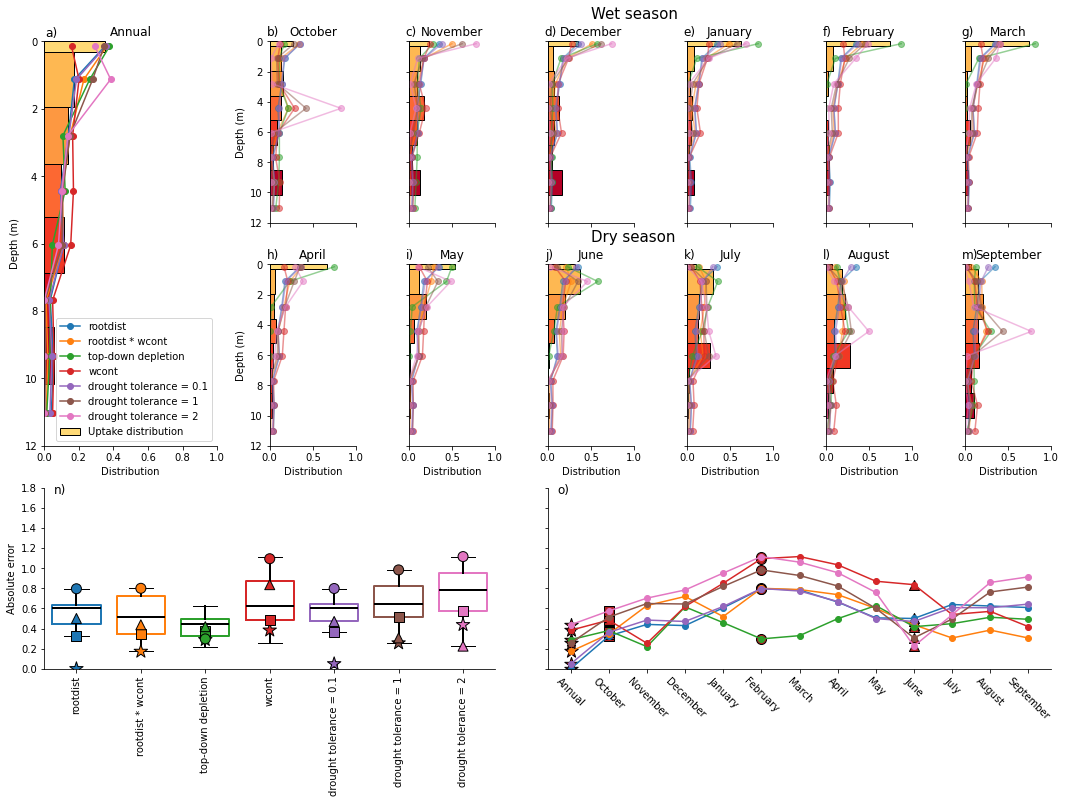

In [70]:
from scipy.stats import pearsonr
from scipy.stats import entropy
def kge(modeled, observed):
    return sum(abs(modeled-observed))
matplotlib.rcParams.update({'font.size': 10})

performance = {key:[] for key in ['month','rdist','rdist_wcont',
                                  'tabplane',
                                 'wcont','drought0.1','drought1',
                                 'drought2',]}

fig = plt.figure(constrained_layout=True, figsize = (15,11),
                )
spec = gridspec.GridSpec(ncols=7, nrows=3, figure=fig, width_ratios=[2,]+[1]*6)

annualax = fig.add_subplot(spec[:-1, 0]) # this is annual
axs = []
for j in range(2):
    for i in range(6):
        axs.append(fig.add_subplot(spec[j,i+1]))
ax1 = fig.add_subplot(spec[2,:3])
ax2 = fig.add_subplot(spec[2,3:])

axall = [annualax,ax1,ax2]+axs
        
ax = annualax
def exp_fun(x,a,b):
    return np.exp(a*x)*b
DeltaStorage_plot = all_outputs[alloutputnum]

uptake_distribution = DeltaStorage_plot.sum()[['ET'+str(l) for l in range(portuse+1)]]
uptake_distribution = uptake_distribution/uptake_distribution.sum()
# uptake_distribution.loc['ET1'] = uptake_distribution.iloc[:2].sum()
# uptake_distribution = uptake_distribution.iloc[1:]
port_widths = [0.3,port_depths[0]]+list(np.array(port_depths[1:portnum])-np.array(port_depths[:portnum-1]))
port_widths[1] = port_widths[1]-.3
moisturedist = DeltaStorage_plot[['SA'+str(i) for i in range(portnum+1)]].dropna().mean()
moisturedist = moisturedist/moisturedist.sum()
# moisturedist.iloc[1] = moisturedist.iloc[:2].sum()
# moisturedist = moisturedist.iloc[1:]
etdist_tab = DeltaStorage_plot[['ETtab'+str(i) for i in range(portnum+1)]].dropna().mean()
etdist_tab = etdist_tab/etdist_tab.sum()
# etdist_tab.iloc[1] = etdist_tab.iloc[:2].sum()
# etdist_tab = etdist_tab.iloc[1:]

for i in range(portnum):
    if i==0:
        label = 'Uptake distribution'
    else:
        label = None
    ax.barh([(np.array([0,0.3]+port_depths[:portnum-1])+np.array(port_widths)/2)[i]],
            [uptake_distribution[i]],
            height = port_widths[i],
            facecolor = colors[i],
           edgecolor = 'k',
           label = label)
xvals = (np.array([0,0.3]+port_depths[:portnum-1])+np.array(port_widths)/2)
rootdist_guess_rootdist = uptake_distribution.values
rootdist_guess_rdistwcont = uptake_distribution.values/moisturedist.values
rootdist_guess_rdistwcont = rootdist_guess_rdistwcont/sum(rootdist_guess_rdistwcont)
rootdist_guess_rdistwcont = rootdist_guess_rootdist

# popt,pcov = curve_fit(exp_fun,xvals,rootdist_guess)
# rootdist = exp_fun(xvals,*popt)
rdist_wcont = rootdist_guess_rdistwcont*moisturedist
rootdist = rootdist_guess_rootdist

ax.plot(rootdist,
           xvals,
           marker='o',
       label = 'rootdist')

ax.plot(rdist_wcont/sum(rdist_wcont),
           xvals,marker='o',
       label = 'rootdist * wcont')

ax.plot(etdist_tab,
       xvals,
        marker='o',
       label='top-down depletion')

# rootdist_smart = DeltaStorage_plot[['SA'+str(i) for i in range(portnum+1)]].dropna().mean()/moisturedist

ax.plot(moisturedist,
           xvals,
           marker='o',
       label = 'wcont')

rdists_drought = []
rdist_guesses = []
for species_drought_tolerance in [0.1,1,2]:
    term2 = np.where(moisturedist**(2.0 * species_drought_tolerance)<moisturedist**.2,
                                               moisturedist**(2.0 * species_drought_tolerance),
                                               moisturedist**.2)
#     rdist_guess_speciesspecific = uptake_distribution.values/term2
#     rdist_guess_speciesspecific = rdist_guess_speciesspecific/sum(rdist_guess_speciesspecific)
    rdist_speciesspecific = rootdist * term2
    ax.plot(rdist_speciesspecific/sum(rdist_speciesspecific),
           xvals,
           marker='o',
       label = 'drought tolerance = '+str(species_drought_tolerance))
    rdists_drought.append(rdist_speciesspecific/sum(rdist_speciesspecific))
    rdist_guesses.append(rdist_speciesspecific)
    
    

ax.set_ylabel('Depth (m)')
ax.set_title('Annual')
ax.legend()
ax.set_ylim(12,0)
ax.set_xlim(0,.5)

performance['month'].append('Annual')
performance['rdist'].append(kge(rootdist,uptake_distribution.values))
performance['rdist_wcont'].append(kge((rdist_wcont/sum(rdist_wcont)).values,
                                      uptake_distribution.values))
performance['wcont'].append(kge(moisturedist.values,uptake_distribution.values))
performance['drought0.1'].append(kge(rdists_drought[0],uptake_distribution.values))
performance['drought1'].append(kge(rdists_drought[1],uptake_distribution.values))
performance['drought2'].append(kge(rdists_drought[2],uptake_distribution.values))
performance['tabplane'].append(kge(etdist_tab.values,uptake_distribution.values))




for j,month in enumerate([10,11,12,1,2,3,4,5,6,7,8,9]):
    ax = axs[j]
    DeltaStorage_month = DeltaStorage_plot[DeltaStorage_plot.reset_index()['index'].dt.month.values==month]
    uptake_distribution = DeltaStorage_month.drop(columns='season').mean()[['ET'+str(l) for l in range(portnum+1)]]*30
    uptake_distribution = uptake_distribution/uptake_distribution.sum()
#     uptake_distribution.iloc[1] = uptake_distribution.iloc[:2].sum()
#     uptake_distribution = uptake_distribution.iloc[1:]
    
    moisturedist = DeltaStorage_month[['SA'+str(i) for i in range(portnum+1)]].dropna().mean()
    moisturedist = moisturedist/moisturedist.sum()
#     moisturedist.iloc[1] = moisturedist.iloc[:2].sum()
#     moisturedist = moisturedist.iloc[1:]
    etdist_tab = DeltaStorage_month[['ETtab'+str(i) for i in range(portnum+1)]].dropna().mean()
    etdist_tab = etdist_tab/etdist_tab.sum()
#     etdist_tab.iloc[1] = etdist_tab.iloc[:2].sum()
#     etdist_tab = etdist_tab.iloc[1:]
    performance['tabplane'].append(kge(etdist_tab.values,uptake_distribution.values))
#     print((abs(etdist_tab.values-uptake_distribution.values)))

    for i in range(portnum):
        ax.barh([(np.array([0,.3]+port_depths[:portnum-1])+np.array(port_widths)/2)[i]],
                [uptake_distribution[i]],
                height = port_widths[i],
                facecolor = colors[i],
               edgecolor = 'k')
    
    ax.plot(rootdist,
           xvals,
           marker='o',
            alpha=.5,
       label = 'rootdist')

    rdist_wcont = rootdist_guess_rdistwcont*moisturedist
    ax.plot(rdist_wcont/sum(rdist_wcont),
               xvals,
               marker='o',
            alpha=.5,
           label = 'rootdist * wcont')
    
    ax.plot(etdist_tab,
           xvals,
           marker='o',
            alpha=.5,
           label='top-down depletion')

#     rootdist_smart = DeltaStorage_month[['SA'+str(i) for i in range(portnum+1)]].dropna().mean()/moisturedist

    ax.plot(moisturedist/sum(moisturedist),
               xvals,
               marker='o',
            alpha=.5,
       label = 'wcont * wcontdist')
    
    
    
    ridsts_drought = []
    for l,species_drought_tolerance in enumerate([0.1,1,2]):
        rootdist_guess = rootdist
        rdist_speciesspecific = rootdist_guess * np.where(moisturedist**(2.0 * species_drought_tolerance)<moisturedist**.2,
                                                   moisturedist**(2.0 * species_drought_tolerance),
                                                   moisturedist**.2)
        ax.plot(rdist_speciesspecific/sum(rdist_speciesspecific),
               xvals,
               marker='o',
                alpha=.5,
           label = 'drought tolerance = '+str(species_drought_tolerance))
        rdists_drought.append(rdist_speciesspecific/sum(rdist_speciesspecific))

    ax.set_title(monthnames[j])
    if j>5:
        ax.set_xlabel('Distribution')
    else:
        ax.set_xticklabels([])
    if j in [0,6]:
        ax.set_ylabel('Depth (m)')
    else:
        ax.set_yticklabels([])
        
    performance['month'].append(str(month))
    performance['rdist'].append(kge(rootdist,uptake_distribution.values))
    performance['rdist_wcont'].append(kge((rdist_wcont/sum(rdist_wcont)).values,
                                          uptake_distribution.values))
    performance['wcont'].append(kge(moisturedist.values,uptake_distribution.values))
    performance['drought0.1'].append(kge(rdists_drought[0],uptake_distribution.values))
    performance['drought1'].append(kge(rdists_drought[1],uptake_distribution.values))
    performance['drought2'].append(kge(rdists_drought[2],uptake_distribution.values))
    
        
# axs[1,0].set_ylabel('Depth (m)')
for ax in axs+[annualax]:
    ax.set_ylim(12,0)
    ax.set_xlim(0,1)
annualax.set_xlim(0,1)
annualax.set_xlabel('Distribution')
    
    
    
    
    
    
monthnames = ['October','November','December','January',
              'February','March','April','May','June',
              'July','August','September'
             ]

ax = ax1
performance = pd.DataFrame.from_dict(performance)
bplots = []
for j,col in enumerate(performance.columns[1:]):
    bplots.append(ax.boxplot(list(performance[col].values),positions=[j],widths=.75,
              boxprops={'lw':2},whiskerprops={'lw':2},zorder = -1,
              medianprops={'lw':2,'c':'k'},flierprops={'lw':2},))

colors1 = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink']
for i,bplot in enumerate(bplots):
    bplot['boxes'][0].set_color(colors1[i])
    
ax.set_ylabel('Absolute error')
ax.scatter(list(range(len(performance.columns)-1)),
           performance.drop(columns='month').iloc[0].T.values,
          marker = '*',edgecolor = 'k',c=colors1,s=200,label = 'Annual')
markers = ['s','o','^']
for j,i in enumerate([1,5,9]):
    ax.scatter(list(range(len(performance.columns)-1)),
               performance.drop(columns='month').iloc[i].T.values,
              edgecolor = 'k',s=100,marker = markers[j],color=colors1,
               label = monthnames[i-1])
ax.set_xticklabels(['rootdist',
                   'rootdist * wcont',
                   'top-down depletion',
                   'wcont',
                   'drought tolerance = 0.1',
                   'drought tolerance = 1',
                   'drought tolerance = 2'],rotation=90)
ax.set_ylim(0,1.8)


ax = ax2
for col in performance.drop(columns='month').columns:
    ax.plot(performance.month,performance[col],label=col,
           marker = 'o')

ax.scatter(['Annual']*len(performance.columns[1:]),
           performance.drop(columns='month').iloc[0].values,
          marker = '*',edgecolor = 'k',c='firebrick',s=200,label = None)
for j,i in enumerate([1,5,9]):
    ax.scatter([i]*len(performance.columns[1:]),
               performance.drop(columns='month').iloc[i].values,
              edgecolor = 'k',s=100,marker = markers[j],c='firebrick',
               label = None)

ax.set_ylim(0,1.8)
ax.set_yticklabels([])
ax.set_xticklabels(['Annual']+monthnames,rotation=360-45)

for ax in axall:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.tight_layout()

labels = ['a)','b)','c)','d)','e)','f)','g)','h)','i)',
         'j)','k)','l)','m)','n)','o)','p)','q)','r)',
          's)','t)','u)','v)']
for i,ax in enumerate([annualax]+axs+[ax1,ax2]):
    for side in ['top','right']:
        ax.spines[side].set_visible(False)

    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    if ax==annualax:
        vert = 1.05
        hor = -.05
    elif ax in axs:
        vert = 1.115
        hor = -.15
    else:
        vert = 1.05
        hor = 0
    ax.text(hor, vert, labels[i], transform=ax.transAxes + trans,
             verticalalignment='top', fontsize = 12)
    
axs[2].text(.5,-1.5,'Wet season',fontsize=15)
axs[8].text(.5,-1.5,'Dry season',fontsize=15)
    
plt.savefig('../uptake_distribution.png',format='png',dpi=300,bbox_inches='tight')

## Look at north/south differences in soil 

In [40]:
SNorth = pd.read_csv('../Data/Snorth.csv')
SNorth['time'] = pd.to_datetime(SNorth['time'])
SNorth.set_index('time',inplace=True)
SSouth = pd.read_csv('../Data/SSouth.csv')
SSouth['time'] = pd.to_datetime(SSouth['time'])
SSouth.set_index('time',inplace=True)
SNorth = SNorth.rename(columns={0.1:'Soil',
                              0.2:'A1',
                              0.3:'A2'})
SSouth = SSouth.rename(columns={0.1:'Soil',
                              0.2:'A1',
                              0.3:'A2'})

In [41]:
num_ports = 1
DSNorth = calc_deltastorage(SNorth,rainData)
DSSouth = calc_deltastorage(SSouth,rainData)
DSNorth = calc_massbalance(DSNorth)
DSSouth = calc_massbalance(DSSouth)

To meet mass balance, increased overall P by  1 %
To meet mass balance, increased overall P by  1 %


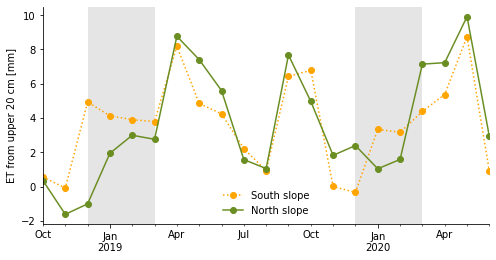

In [50]:
ETsouth = DSSouth[['ET0','ET1']].sum(axis=1).resample('M').sum()
ETnorth = DSNorth[['ET0','ET1']].sum(axis=1).resample('M').sum()

fig,ax = plt.subplots(1,figsize = (8,4))
ETsouth.plot(label='South slope',marker = 'o',c='orange',ls=':')
ETnorth.plot(label='North slope', marker='o',c='olivedrab')
ax.axvspan(pd.to_datetime('12-1-2018'),pd.to_datetime('3-1-2019'),facecolor='k',alpha=.1)
ax.axvspan(pd.to_datetime('12-1-2019'),pd.to_datetime('3-1-2020'),facecolor='k',alpha=.1)
plt.legend(frameon=False)
plt.ylabel('ET from upper 20 cm [mm]')
ax.spines[['top','right']].set_visible(False)

plt.savefig('etdiff.png',format='png',dpi=300,bbox_inches='tight')

In [54]:
ETnorth_monthly-ETsouth_monthly

1    -2.243010
2    -1.245638
3     0.862280
11    0.140831
12   -1.606389
dtype: float64

In [56]:
ETnorth_monthly = ETnorth.groupby(ETnorth.index.month).mean()
ETsouth_monthly = ETsouth.groupby(ETsouth.index.month).mean()
ETnorth_monthly = pd.concat([ETnorth_monthly.iloc[:3],ETnorth_monthly.iloc[10:]])
ETsouth_monthly = pd.concat([ETsouth_monthly.iloc[:3],ETsouth_monthly.iloc[10:]])
(ETnorth_monthly-ETsouth_monthly).sum()/ETnorth_monthly.sum()

-0.43034625779877184

## Explore impact of choosing a given probe

In [77]:
# import tdr data (soil moisture)
tdr = ''
if len(tdr)==0:
    tdr = pd.read_csv('https://raw.githubusercontent.com/hydroeco/hydroeco.github.io/master/angelo/angelo_tdr_1H.csv')
    tdr['timestamp_local'] = pd.to_datetime(tdr.timestamp_local)
    tdr = tdr[[c for c in tdr.columns if ('Soil_Moisture' in c) & ('L3S' in c)]+['timestamp_local']]
    tdr.set_index('timestamp_local',inplace=True)
    tdr_probes = tdr.columns.values
    seps = [t.split('_') for t in tdr_probes]


depths = [float(t[-1]) for t in seps[:6]]+[float(t[-1][:-2]) for t in seps[6:]]
depths = {tdr_probes[i]:depths[i] for i in range(len(depths))}
depth_cat = [0.3,0.3,0.3,]#0.3,0.3,0.3,100,138,15,35,70]

# tdr = tdr[['RivLevel31_Soil_Moisture_L3S3_0.30']]
# depth_cat = depth_cat[:1]

depth_category = {0.3:tdr_probes[:3],
#                  100:tdr_probes[6:7],
#                  138:tdr_probes[7:8],
#                  15:tdr_probes[8:9],
#                  35:tdr_probes[9:10],
#                  70:tdr_probes[10:]
                 }

for col in tdr.columns:
    tdr[col] = np.where(tdr[col]<0,np.nan,tdr[col])
    tdr[col] = np.where((tdr.index>'2018-10-01') &(tdr.index<'2019-4-01') & (tdr[col]>.055),
                    np.nan,tdr[col])
#     tdr[col] = tdr[col].interpolate()
for cat in list(dict.fromkeys(depth_cat)):
    tdr[cat] = tdr[depth_category[cat]].mean(axis=1)

# process tdr data
vms_tdr_clipped = tdr[tdr>0].loc['2016-10-01':'2020-10-01']

tdr_filtered=vms_tdr_clipped.copy()

for col in vms_tdr_clipped.columns:
    temp = np.array(vms_tdr_clipped[col].ffill().bfill())

    N  = 3    # Filter order 2
    Wn = .01 # Cutoff frequency 0.001
    B, A = signal.butter(N, Wn, output='ba')

    # Second, apply the filter
    tempf = signal.filtfilt(B,A, temp)
    tdr_filtered[col]=tempf
    tdr_filtered[col] = np.where(tdr_filtered[col]>.055,np.nan,tdr_filtered[col])
    tdr_filtered[col] = tdr_filtered[col].interpolate()

ranges = (tdr_filtered.max()-tdr_filtered.min())
mins = tdr_filtered.min()
tdr_normalized=(tdr_filtered)
for col in tdr_normalized:
    tdr_normalized[col] = (tdr_normalized[col]-mins[col])/ranges[col]

tdr_norm = tdr_normalized#[[0.3,]].rename(columns={0.3:0})#.mean(axis=1).to_frame()
tdr_norm['wy'] = np.where(tdr_norm.index.month>9,tdr_norm.index.year+1,
                         tdr_norm.index.year)
wymins = tdr_norm.groupby('wy').min()
wymaxs = tdr_norm.groupby('wy').max()


for col in tdr_normalized.columns:
    normed = []
    for yr in wymins.index:
        tdr_yr = tdr_norm[tdr_norm.wy==yr][col]
        tdr_yr = (tdr_yr-wymins.loc[yr].values[0])/(wymaxs.loc[yr].values[0]-wymins.loc[yr].values[0])
        normed = normed + list(tdr_yr.values)
    tdr_norm[col] = normed

# soil_dynamic_storage = soilStore # mm
# tdr_norm.rename(columns={0:'final'},inplace=True)
# soil_flux = tdr_norm['final']*soil_dynamic_storage

# tdr_norm.plot()
tdr_norm_final = tdr_norm.copy()

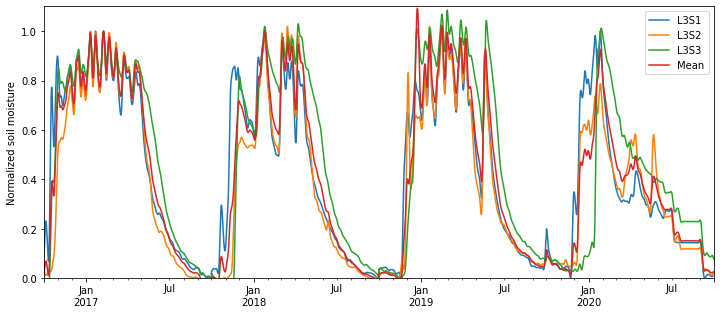

In [78]:
tdr_norm_final.iloc[:-50].drop(columns='wy').rename(columns={'RivLevel31_Soil_Moisture_L3S1_0.33':'L3S1',
                                                             'RivLevel31_Soil_Moisture_L3S2_0.27':'L3S2',
                                                             'RivLevel31_Soil_Moisture_L3S3_0.30':'L3S3',
                                                             0.3:'Mean'}).plot(figsize = (12,5))
plt.legend()#bbox_to_anchor = (1.5,1.5))
plt.ylabel('Normalized soil moisture')
plt.xlabel('')
plt.ylim(0,1.1)

plt.savefig('soil_probes.png',format='png',dpi=300,bbox_inches='tight')
# tdr_norm.plot()
# plt.ylim(0,1)

In [79]:
# run mass balance technique for all possible maximum depths

probe_outputs = []
rdstore = 425
num_ports = 7
soilStore = 89
tdr_norms = [tdr_norm_final[[c]].rename(columns={c:'final'}) for c in tdr_normalized.columns if c not in ['wy',]]

for i in range(len(tdr_norms)):
    print('Number of ports:',num_ports)

    pet,popt,tdtData,tdr_norm,rainData = import_data(num_ports)
    tdr_norm = tdr_norms[i].copy()
    Storages = setup_storage(popt,tdtData,tdr_norm,rdstore,num_ports,'exp')
    DeltaStorage = calc_deltastorage(Storages,rainData)
    DeltaStorage = calc_massbalance(DeltaStorage)

    DS_sub = DeltaStorage.loc['2016-10-01':'2019-10-01']

    print(DS_sub.ET_total.mean()*365,
          DeltaStorage.ET_total.mean()*365/DeltaStorage.Jadjust.mean()*365)
    
    probe_outputs.append(DeltaStorage)



Number of ports: 7
[92.82362296 92.54433817 73.49859864 65.7127174  27.07268308 23.84867633
 20.85644503 14.81765063 13.82526774]
To meet mass balance, increased overall P by  8 %
529.1370002503926 28756.259148368896
Number of ports: 7
[92.82362296 92.54433817 73.49859864 65.7127174  27.07268308 23.84867633
 20.85644503 14.81765063 13.82526774]
To meet mass balance, increased overall P by  9 %
497.31559104850345 27508.441972138862
Number of ports: 7
[92.82362296 92.54433817 73.49859864 65.7127174  27.07268308 23.84867633
 20.85644503 14.81765063 13.82526774]
To meet mass balance, increased overall P by  7 %
477.11078043288296 26299.445146202877
Number of ports: 7
[92.82362296 92.54433817 73.49859864 65.7127174  27.07268308 23.84867633
 20.85644503 14.81765063 13.82526774]
To meet mass balance, increased overall P by  7 %
497.29490864589536 27345.65346067956


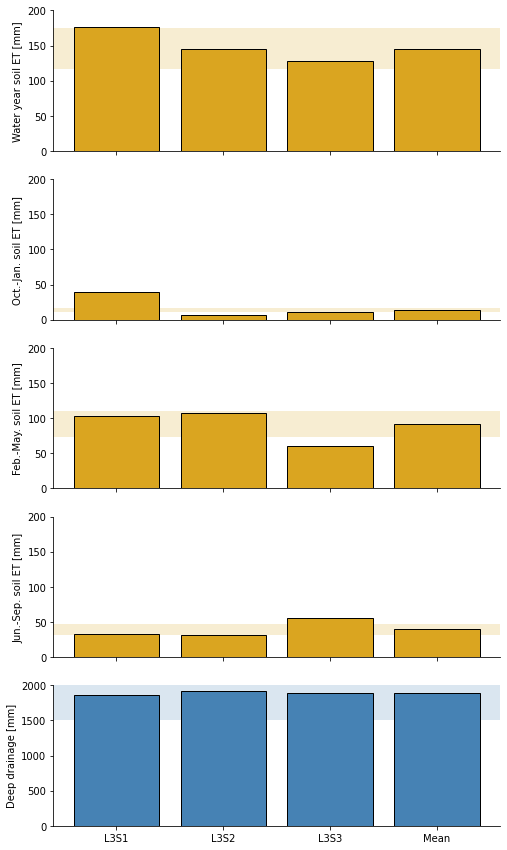

In [80]:
ETsums_soil = []
ETsums = []
ETsums_winter = []
ETsums_spring = []
ETsums_summer = []
Qsums = []

for i in range(len(probe_outputs)):
    p1 = probe_outputs[i]
    p1 = p1.loc[:'2019-10-01']
    ETsums_soil.append(p1.ET0.sum()/3)
    ETsums.append(p1.ET_total.sum()/3)
    ETsums_winter.append(p1[p1.index.month.isin([10,11,12,1])].ET0.sum()/3)
    ETsums_spring.append(p1[p1.index.month.isin([2,3,4,5])].ET0.sum()/3)
    ETsums_summer.append(p1[p1.index.month.isin([6,7,8,9])].ET0.sum()/3)
    Qsums.append(p1.d7.sum()/3)
    
fig,axs = plt.subplots(5,figsize = (8,15),sharex=True,)

bars = [ETsums_soil,ETsums_winter,ETsums_spring,ETsums_summer,Qsums]

for j in range(len(bars)):
    ax = axs[j]
    bardata = bars[j]
    fcolor = 'goldenrod'
    if j==4:
        fcolor = 'steelblue'
    ax.bar(list(range(4)),bardata,edgecolor = 'k',facecolor = fcolor)
    ax.spines[['top','right']].set_visible(False)
    ax.set_ylim(0,200)
    ax.axhspan(bardata[-1]*.8,bardata[-1]*1.2,facecolor = fcolor,zorder=-1,alpha=.2)
ax.set_ylim(0,2000)

ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['L3S1','L3S2','L3S3','Mean'])
axs[0].set_ylabel('Water year soil ET [mm]')
axs[1].set_ylabel('Oct.-Jan. soil ET [mm]')
axs[2].set_ylabel('Feb.-May. soil ET [mm]')
axs[3].set_ylabel('Jun.-Sep. soil ET [mm]')
axs[4].set_ylabel('Deep drainage [mm]')

plt.savefig('probe_compare.png',format='png',dpi=300,bbox_inches='tight')

In [81]:
Qsums

[1865.8430082091397, 1912.0136299320432, 1894.089294230278, 1885.1402397458514]

In [82]:
ETsums_soil

[176.74140157538022,
 145.62282446370378,
 127.31072194797305,
 145.24045201198294]

In [83]:
ETsums

[525.2711591526728, 493.68223513216736, 473.6250395712729, 493.6617038338706]

In [84]:
(176-146)/146

0.2054794520547945

## Check out the well data

(-0.25, 0.0)

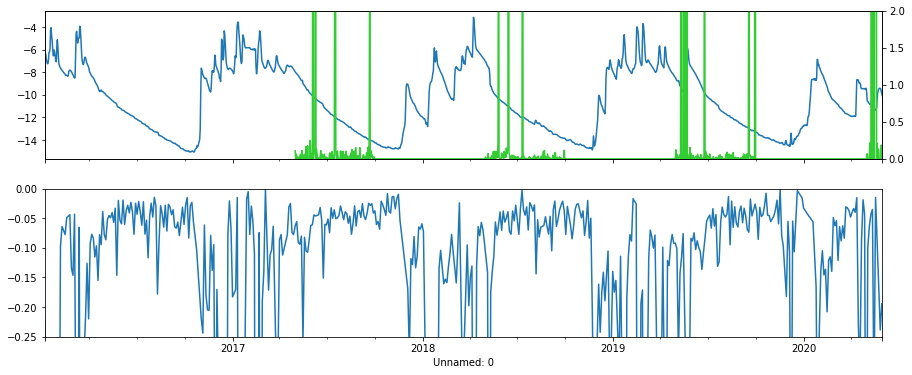

In [85]:
fig,axs = plt.subplots(2,figsize = (15,6),sharex=True)

ax = axs[0]
welldata = pd.read_csv('../Data/data_for_datafig.csv')[['Unnamed: 0',
                                                        'well_10_adjust','well_07_adjust']]
welldata['Unnamed: 0'] = pd.to_datetime(welldata['Unnamed: 0'])
welldata.set_index('Unnamed: 0',inplace=True)
welldata.well_07_adjust.plot(ax=ax)
axt = ax.twinx()
DeltaStorage[DeltaStorage.index.month.isin([5,6,7,8,9])].resample('D').sum().d7.plot(ax=axt,c='limegreen')
axt.set_ylim(0,2)

ax = axs[1]
# fig,ax = plt.subplots(1,figsize = (15,3))
wellshift = welldata.diff().resample('3D').min()
wellshift[wellshift.well_07_adjust<0].well_07_adjust.plot(ax=ax)
ax.set_ylim(-.25,0)

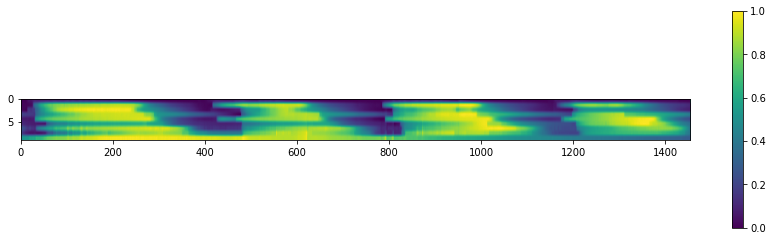

In [86]:
fig,ax = plt.subplots(1,figsize = (15,4))
SRel = Storages.copy()
for col in SRel.columns:
    SRel[col] = SRel[col]/SRel[col].max()
im = ax.imshow(SRel.to_numpy().T,extent=[0,len(SRel),len(SRel.columns),0], aspect=10)
plt.colorbar(im)